# DAAO venues and organisations

<style>
  a {
    color: #1ea5a6 !important;
  }
</style>

This is an exploratory data analysis of collected data from [DAAO](https://www.daao.org.au/). We focus on venues and organisations adopting natural language processing to reveal patterns in the data.

The visualisations consist of...
- word clouds
- dendrograms
- time series and temporal bar charts

In [1]:
import requests, gzip, io, json, pandas as pd

# df = fetch_data(acdedata='recognition') # 1.6s
# df = fetch_data(acdedata='recognition', filetype='jsonl') # 0.5s
# df = fetch_data(acdedata='recognition', source='googledrive') # 12s
# df = fetch_data(acdedata='recognition', filetype='jsonl', source='googledrive') # 4.6s

def fetch_data(filetype='csv', acdedata='organization', source='googledrive'):
    download_url = None
    github_url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/{filetype}/acde_{acdedata}_202305080816.{filetype}.gz"

    if source == 'googledrive':
        urls = pd.read_csv('data/data_urls.csv')
        sharelink = urls[urls.data == acdedata][filetype].values[0]
        url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'

    elif source == 'github': url = github_url
    else: return None
    
    response = requests.get(url)

    try:
        sha = response.content.decode('utf-8').splitlines()[1].split('oid sha256:')[-1]
        size = response.content.decode('utf-8').splitlines()[2].split('size ')[-1]

        # Step 1: Create the JSON object
        json_data = {"operation": "download", "transfer": ["basic"], "objects": [{"oid": sha, "size": int(size)}]}

        # Step 2: Send a POST request to the LFS API
        url = "https://github.com/acd-engine/jupyterbook.git/info/lfs/objects/batch"
        headers = {"Accept": "application/vnd.git-lfs+json","Content-type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(json_data))
        response_json = response.json()

        # Step 3: Extract the download URL from the response
        download_url = response_json["objects"][0]["actions"]["download"]["href"]
    except:
        pass

    if download_url is not None: response = requests.get(download_url)

    decompressed_data = gzip.decompress(response.content)
    decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))

    try:
        if filetype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
        else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
        return pd.DataFrame(df)
    except: return None 

In [171]:
import numpy as np
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import requests, gzip, io, json, pandas as pd
import ast

# def fetch_data(ftype='csv', acdedata='event'):
#     urls = pd.read_csv('data/data_urls.csv')
#     sharelink = urls[urls.data == acdedata][ftype].values[0]
#     url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'
#     response = requests.get(url)
#     decompressed_data = gzip.decompress(response.content)
#     decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))
#     try:
#         if ftype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
#         else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
#         return pd.DataFrame(df)
#     except: return None

#     # with requests.get(url, stream=True) as response:
#     #     response.raise_for_status()
#     #     with gzip.GzipFile(fileobj=response.raw) as f:
#     #         if filetype == 'csv': df = pd.read_csv(f, low_memory=False)
#     #         else: df = pd.json_normalize([json.loads(json.loads(line)) for line in f])

# # read in data
# dfs = fetch_data(ftype='csv', acdedata='event') #42 secs
# dfs = fetch_data(acdedata='event') # 1.6s

# dfs_expanded = []

# # get start and end years - 20 secs
# for idx,row in dfs[dfs.data_source.str.contains('DAAO')].iterrows():

#     try: 
#         this_locations = pd.json_normalize(ast.literal_eval(row['coverage_ranges']))

#         for idx2, row2 in this_locations.iterrows():
#             try: start_yr = row2['date_range.date_start.year']
#             except: start_yr = None

#             try: end_yr = row2['date_range.date_end.year']
#             except: end_yr = None

#             try: place_address = row2['place.ori_address']
#             except: place_address = None

#             try: 
#                 latitude = row2['place.geo_coord.latitude']
#                 longitude = row2['place.geo_coord.longitude']
#             except:
#                 latitude = None; longitude = None

#             row['start_year'] = int(start_yr); row['end_year'] = int(end_yr)
#             row['latitude'] = latitude; row['longitude'] = longitude
#             row['place_address'] = place_address
#             dfs_expanded.append(row)

#     except:
#         start_yr = None; end_yr = None; latitude = None; longitude = None; place_address = None
#         dfs_expanded.append(row)

# dfs_expanded = pd.DataFrame(dfs_expanded)

# pd.DataFrame(dfs_expanded).to_csv('data/acde_event_expanded.csv', index=False)

# read in expanded data
dfs_expanded = pd.read_csv('data/acde_event_expanded.csv', low_memory=False).drop_duplicates()

locations_cond = dfs_expanded.latitude.notnull()
year_cond = dfs_expanded.start_year.notnull()
desc_cond = dfs_expanded.description.notnull()
period_cond = (dfs_expanded.start_year >= 1900) & (dfs_expanded.start_year <= 2020)

print('In DAAO,') 
print(f'- there are {dfs_expanded.shape[0]} events.')
print(f'- there are {dfs_expanded[year_cond].shape[0]} events with dates.')
print(f'- there are {dfs_expanded[locations_cond & year_cond].shape[0]} events with geocodes and dates.')
print(f'- there are {dfs_expanded[locations_cond & year_cond & desc_cond].shape[0]} events with geocodes, dates and biographical information.')
print(f'- there are {dfs_expanded[locations_cond & year_cond & desc_cond & period_cond].shape[0]} events with geocodes, dates and biographical information after filtering for events between 1900 and 2020.')

In DAAO,
- there are 21838 events.
- there are 20544 events with dates.
- there are 17214 events with geocodes and dates.
- there are 7418 events with geocodes, dates and biographical information.
- there are 7248 events with geocodes, dates and biographical information after filtering for events between 1900 and 2020.


In [176]:
dfs_rich = dfs_expanded[locations_cond & year_cond & desc_cond & period_cond].copy()

type_count = dfs_rich['types'].value_counts().reset_index().rename(columns={'index':'type','types':'count'})
type_count['prop'] = round((type_count['count']/dfs_rich.shape[0])*100,2)
exh_prop = type_count['type'].str.contains('exhibition')
other_prop = type_count['type'].str.contains('other event')
fest_prop = type_count['type'].str.contains('festival')
perf_prop = type_count['type'].str.contains('performance')

# # create a decade column
dfs_rich['decade_start'] = [str(int(x))[:3]+'0' for x in dfs_rich['start_year']]
dfs_rich['decade_start'] = dfs_rich['decade_start'].astype(int)

print('\nWe use the 7,248 events for the remainder of the analysis. In this subset,') 
print(f'- there are {type_count[exh_prop]["count"].sum()} exhibitions ({round(type_count[exh_prop]["prop"].sum(),2)}%).')
print(f'- there are {type_count[other_prop]["count"].sum()} other-events ({round(type_count[other_prop]["prop"].sum(),2)}%).')
print(f'- there are {type_count[fest_prop]["count"].sum()} festivals ({round(type_count[fest_prop]["prop"].sum(),2)}%).')
print(f'- there are {type_count[perf_prop]["count"].sum()} performance-event ({round(type_count[perf_prop]["prop"].sum(),2)}%).')
print(f'- there are {dfs_rich["types"].isnull().sum()} events with missing type data ({round((dfs_rich["types"].isnull().sum()/dfs_rich.shape[0])*100,2)}%).')

print('\nIn terms of time,')
for t in range(1900,2021,10):
    if t != 2020: print(f'- there are {dfs_rich[dfs_rich.decade_start == t].shape[0]} events between {t}-{t+10} ({round((dfs_rich[dfs_rich.decade_start == t].shape[0]/dfs_rich.shape[0])*100,2)}%).')
    else: print(f'- there are {dfs_rich[dfs_rich.start_year == t].shape[0]} events in {t} ({round((dfs_rich[dfs_rich.start_year == t].shape[0]/dfs_rich.shape[0])*100,2)}%).')


We use the 7,248 events for the remainder of the analysis. In this subset,
- there are 6629 exhibitions (91.46%).
- there are 85 other-events (1.17%).
- there are 31 festivals (0.43%).
- there are 20 performance-event (0.28%).
- there are 488 events with missing type data (6.73%).

In terms of time,
- there are 33 events between 1900-1910 (0.46%).
- there are 31 events between 1910-1920 (0.43%).
- there are 39 events between 1920-1930 (0.54%).
- there are 40 events between 1930-1940 (0.55%).
- there are 41 events between 1940-1950 (0.57%).
- there are 90 events between 1950-1960 (1.24%).
- there are 159 events between 1960-1970 (2.19%).
- there are 629 events between 1970-1980 (8.68%).
- there are 1333 events between 1980-1990 (18.39%).
- there are 2141 events between 1990-2000 (29.54%).
- there are 2216 events between 2000-2010 (30.57%).
- there are 493 events between 2010-2020 (6.8%).
- there are 3 events in 2020 (0.04%).


## Most frequent geocodes

Before jumping into the visuals, we inspect the nuances of the geocodes attached to exhibtion data. We find that the geocodes are not always accurate, and that there are many distinct venues representing the same geocode. Further pre-processing will need to be conducted to ensure downstream trends can be accurately identified. 

Below is a list of the top 20 geocodes, and the number of events they represent. Through further inspection we can see which geocodes accurate represent the place names.

In [177]:
most_freq_geocodes = dfs_rich[['latitude','longitude']].value_counts().reset_index().rename(columns={0:'Frequency'})
most_freq_geocodes = most_freq_geocodes.head(20)

# get the most frequent place_address for each geocode
for idx,row in most_freq_geocodes.iterrows():
    place_address = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[0]

    try: place_address2 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[1]
    except: place_address2 = None
    
    try: place_address3 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[2]
    except: place_address3 = None

    try: place_address4 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[3]
    except: place_address4 = None

    try: place_address5 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[4]
    except: place_address5 = None
    
    most_freq_geocodes.loc[idx,'most_frequent_address'] = place_address
    most_freq_geocodes.loc[idx,'2ndmost_frequent_address'] = place_address2
    most_freq_geocodes.loc[idx,'3rdmost_frequent_address'] = place_address3
    most_freq_geocodes.loc[idx,'4thmost_frequent_address'] = place_address4
    most_freq_geocodes.loc[idx,'5thmost_frequent_address'] = place_address5

most_freq_geocodes

,latitude,longitude,Frequency,most_frequent_address,2ndmost_frequent_address,3rdmost_frequent_address,4thmost_frequent_address,5thmost_frequent_address
0,-34.928621,138.599959,923,"Experimental Art Foundation, Adelaide, SA","Contemporary Art Centre of South Australia, Ad...","Adelaide Central Gallery, Adelaide, SA","Greenaway Art Gallery, Adelaide, SA","Flinders University Art Museum, Adelaide, SA"
1,-33.868901,151.207091,887,"Artspace, Sydney, NSW","Sydney, NSW","Sherman Galleries, Sydney, NSW","Ivan Dougherty Gallery, Sydney, NSW","Australian Centre for Photography, Sydney, NSW"
2,-27.470933,153.023502,488,"Institute of Modern Art, Brisbane, QLD","Brisbane City Art Gallery, Brisbane, Qld","Brisbane, Qld","University of Queensland Art Museum, Brisbane,...","Brisbane, QLD"
3,-37.813187,144.962980,486,"Monash University Museum of Art, Melbourne, VIC","RMIT Gallery, Melbourne, VIC","Australian Centre for Contemporary Art, Melbou...","Karen Woodbury Gallery, Melbourne, Vic.","Melbourne, Vic."
4,-33.868627,151.217062,292,"Art Gallery of New South Wales, Sydney, NSW","Art Gallery of NSW, Sydney, NSW","Art Gallery Of New South Wales, Sydney, NSW","[National] Art Gallery of New South Wales, Syd...","Art Gallery of New South Wales, Sydney, 14 Oct..."
5,-34.416667,150.883333,183,"Wollongong City Gallery, Wollongong, NSW","Wollongong City Art Gallery, Wollongong, NSW","Project Contemporary Artspace, Wollongong, NSW","Wollongong City Gallery, NSW","Project Centre for Contemporary Art, Wollongon..."
6,-12.437368,130.833821,128,Museums and Art Galleries of the Northern Terr...,Museum and Art Gallery of the Northern Territo...,Museum & Art Gallery of the Northern Territory...,Museum and Art Gallery of the Northern Territo...,Museums and Art Galleries of the Northern Terr...
7,-37.822536,144.969113,124,"National Gallery of Victoria, Melbourne, VIC","National Gallery of Victoria, Melbourne, Vic.","Ian Potter Centre, National Gallery of Victori...","Access Gallery, National Gallery of Victoria, ...","National GAllery of Victoria, Melbourne, Vic."
8,-31.952222,115.858889,116,"John Curtin Gallery, Curtin University, Perth, WA","Perth, WA","Perth Institute of Contemporary Art, Perth, WA","Greenhill Galleries, Perth, WA","Katanning Arts Centre, Katanning & Western Aus..."
9,-27.472096,153.018173,113,"Queensland Art Gallery, Brisbane, QLD","Queensland Art Gallery, Brisbane, Qld","Queensland Art Gallery, Brisbane, Qld.","Queensland Art Gallery, Brisbane. QLD","Queensland Art Gallery, Brsbane, QLD"


### Top 10 geocoded places with most events

After omitting geocodes with random or erroneous place names, we can see that the "true" top 10 geocoded places with the most events. As expected these are all art galleries - all with over 100 events.

| Venue | City | Frequency |
| :- | -: | -: |
| Art Gallery of New South Wales | Sydney, NSW | 292 |
| Wollongong City Gallery | Wollongong, NSW | 183 |
| Museums and Art Galleries of the Northern Territory | Darwin, NT | 128 |
| National Gallery of Victoria | Melbourne, VIC | 124 |
| Queensland Art Gallery | Brisbane, QLD	| 113 |
| Newcastle Region Art Gallery | Newcastle, NSW | 106 |
| Orange Regional Gallery | Orange, NSW | 102 |
| Warrnambool Art Gallery | Warrnambool, VIC | 99 |
| 8 Llankelly Place, Kings Cross | Sydney, NSW | 96 |
| Art Gallery of Western Australia | Perth, WA | 90 |

## Data pre-processing

We split the cleaning process into two parts.
- First, we aggregate place names with the same geocodes, however we only do this for geocodes with no conflicting places i.e., erroneous geocodes. We manually checked this for the top 100 geocodes.
- Next, we use the `geopy` library to convert the place names into geocodes. This helps us identify erroneous place names, and also helps us identify duplicate venues. There are only 34.2% of venues that have a geocode attached to them - these are handled accordingly keeping only venues with more than 4 exhibitions.
- The remaning venues are cleaned using edit distancing. If two place names share more than 75% common characters, then they are considered the same place. This is a very conservative threshold, but it is necessary to ensure that we do not merge two distinct places. Again we only keep venues with more than 4 exhibitions.

### Aggregate place names with no geocode/address conflicts

In [178]:
qag_dict = dfs_rich[dfs_rich.place_address == 'Queensland Art Gallery, Brisbane, QLD'][['latitude','longitude']]\
            .head(1).T.iloc[:,0].to_list()

qvmag_dict = dfs_rich[dfs_rich.place_address == 'Queen Victoria Museum and Art Gallery, Launceston, TAS'][['latitude','longitude']]\
            .head(1).T.iloc[:,0].to_list()

fix_these_placenames = ['Art Gallery of New South Wales, Sydney, NSW',
 'National Gallery of Victoria, Melbourne, VIC',
 'Museums and Art Galleries of the Northern Territory, Darwin, NT',
 'Queensland Art Gallery, Brisbane, QLD', 
 'Queensland Museum, Brisbane, QLD',
 'Newcastle Region Art Gallery, Newcastle, NSW',
 'Orange Regional Gallery, Orange, NSW',
 'Warrnambool Art Gallery, Warrnambool, VIC',
 'Art Gallery of Western Australia, Perth, WA',
 'Queen Victoria Museum and Art Gallery, Launceston, TAS',
 'University Gallery, Launceston, Tas.',
 'Ballarat Fine Art Gallery, Ballarat, VIC',
 'Ian Potter Museum of Art, University of Melbourne, Melbourne, Vic.',
 'Heide Museum of Modern Art, Melbourne, VIC',
 'Art Gallery of South Australia, Adelaide, SA',
 'National Gallery of Australia, Canberra, ACT',
 'Tasmanian Museum and Art Gallery, Hobart, TAS',
 'Plimsoll Gallery, University of Tasmania, Hobart, TAS',
 'University of South Australia, Adelaide, SA',
 'Lawrence Wilson Art Gallery, University of Western Australia, Perth, WA',
 'University of Melbourne, Melbourne, Vic',
 'S.H. Ervin Gallery, Sydney, NSW',
 'Ace of Clubs Hall, Redcliffe, QLD',
 'NSW Parliament House, Sydney, NSW',
 'Campbelltown City Art Gallery, Campbelltown, NSW',
 'Ivan Dougherty Gallery, University of New South Wales, Sydney, NSW',
 'New England Regional Art Museum, Armidale, NSW',
 'Geelong Art Gallery, Geelong, VIC',
 'Bathurst Regional Art Gallery, Bathurst, NSW',
 'Bendigo Art Gallery, Bendigo, VIC',
 'Shanghai Art Gallery, Shanghai, China',
 'Glen Eira City Gallery, Melbourne, Vic.',
 'Penrith Regional Gallery, Penrith, NSW',
 'John Curtin Gallery, Curtin University of Technology, Perth, WA',
 'Tandanya National Aboriginal Cultural Institute, Adelaide, SA',
 'Mosman Art Gallery, Mosman, NSW',
 'Casula Powerhouse Arts Centre, Casula, NSW',
 'Tamworth Regional Gallery, Tamworth, NSW',
 'Royal Exhibition Building, Melbourne, VIC',
 'Gomboc Gallery, Perth, WA',
 'Albury Regional Art Centre, Albury, NSW',
 'Manly Art Gallery & Museum, Manly, Sydney, NSW',
 'Devonport Regional Gallery, Devonport, Tas.',
 'State Library of NSW, Sydney, NSW']

# iterate over fix_these_placenames and update place names of rows with matching geocodes
for place in fix_these_placenames:
    this_place = dfs_rich[dfs_rich.place_address == place].head(1)
    matching_geocodes = dfs_rich[(dfs_rich.latitude == this_place['latitude'].values[0]) &\
                                 (dfs_rich.longitude == this_place['longitude'].values[0])]
    
    # use index of matching_geocodes to replace place_address with place
    dfs_rich.loc[matching_geocodes.index,'place_address'] = place

dfs_rich.loc[dfs_rich.place_address == 'Queensland Museum, Brisbane, QLD',['latitude','longitude']] = qag_dict
dfs_rich.loc[dfs_rich.place_address == 'University Gallery, Launceston, Tas.',['latitude','longitude']] = qvmag_dict

# iterate over fix_these_placenames and update place names of rows with matching geocodes
for place in ['Queensland Art Gallery, Brisbane, QLD','Queen Victoria Museum and Art Gallery, Launceston, TAS']:
    this_place = dfs_rich[dfs_rich.place_address == place].head(1)
    matching_geocodes = dfs_rich[(dfs_rich.latitude == this_place['latitude'].values[0]) &\
                                 (dfs_rich.longitude == this_place['longitude'].values[0])]
    
    # use index of matching_geocodes to replace place_address with place
    dfs_rich.loc[matching_geocodes.index,'place_address'] = place

### Cleaning by aggregating by geocode

In [179]:
# import geopandas # !pip install geopandas
# import geopy # !pip install geopy
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

# venue_addresses = pd.DataFrame(dfs_rich['place_address'].unique()).rename(columns={0:'address_prompt'})

# # 40 min process
# locator = Nominatim(user_agent="myGeocoder")

# # 1 - conveneint function to delay between geocoding calls
# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# # 2- - create location column
# venue_addresses['location'] = venue_addresses['address_prompt'].apply(geocode)

# # 3 - create longitude, laatitude and altitude from location column (returns tuple)
# venue_addresses['point'] = venue_addresses['location'].apply(lambda loc: tuple(loc.point) if loc else None)

# # 4 - split point column into latitude, longitude and altitude columns
# venue_addresses[['latitude2', 'longitude2', 'altitude2']] = pd.DataFrame(venue_addresses['point'].tolist(), index=venue_addresses.index)

# # save csv
# venue_addresses.to_csv('data/venue_addresses_geocoded_v2.csv',index=False)

# read csv
venue_addresses = pd.read_csv('data/venue_addresses_geocoded_v2.csv')

print(f'{round(venue_addresses["point"].notnull().sum()/venue_addresses.shape[0],2)*100}% of the addresses could be geocoded.')

33.0% of the addresses could be geocoded.


In [180]:
# join the geocoded addresses to the dfs_rich
dfs_rich2 = dfs_rich.merge(venue_addresses,how='left',left_on='place_address',right_on='address_prompt')
dfs_rich2.loc[dfs_rich2['place_address'].str.contains('University of South Australia',na=False),'location':] = np.nan # fix one address
# print(f'{round(dfs_rich2[dfs_rich2["latitude2"].notnull()].shape[0]/dfs_rich2.shape[0],2)*100}% of the events could be geocoded.')

dfs_rich_uncoded = dfs_rich2[(dfs_rich2["latitude2"].isnull()) | (dfs_rich2["address_prompt"].isnull())].copy()
dfs_rich_coded = dfs_rich2[(dfs_rich2["latitude2"].notnull()) & (dfs_rich2["address_prompt"].notnull())].copy()
# dfs_rich_coded = dfs_rich2[(dfs_rich2["latitude2"].notnull()) & (dfs_rich2["address_prompt"].notnull())].copy()[['place_address',
#                                                                      'decade_start',
#                                                                      'latitude','longitude',
#                                                                      'address_prompt',
#                                                                      'location','point',
#                                                                      'latitude2','longitude2']]

# keep rows with Frequency over 4
dfs_rich_coded_counts = dfs_rich_coded[['point']].value_counts().reset_index().rename(columns={0:'Frequency'})
unique_points = dfs_rich_coded_counts[dfs_rich_coded_counts['Frequency'] > 4]['point'].values
dfs_rich_coded_top = dfs_rich_coded[dfs_rich_coded['point'].isin(unique_points)].copy()

# keep rows with Frequency over 4
dfs_rich_uncoded_counts = dfs_rich_uncoded[['latitude','longitude']].value_counts().reset_index().rename(columns={0:'Frequency'})
unique_longlats = dfs_rich_uncoded_counts[dfs_rich_uncoded_counts['Frequency'] > 4][['latitude','longitude']].values
dfs_rich_uncoded_top = dfs_rich_uncoded[dfs_rich_uncoded['latitude'].isin(unique_longlats[:,0]) & dfs_rich_uncoded['longitude'].isin(unique_longlats[:,1])].copy()

In [181]:
verified_df = pd.DataFrame()

ignore_these = ['Melbourne, Vic.','Brisbane, Qld','Sydney, NSW','Fremantle, WA','Hobart, TAS','Adelaide, SA',
                'Berlin, Germany','Paris, France','London, England, UK','New York, USA','Gold Coast, QLD','Perth, WA',
                'Newcastle, NSW','Auckland, NZ','Bondi, Sydney, NSW','Canberra, ACT','Launceston, TAS']

for idx, row in enumerate(dfs_rich_coded_top.point.unique()):
    thisrow = dfs_rich_coded_top[dfs_rich_coded_top.point == row].copy()
    topcount = thisrow['address_prompt'].value_counts().reset_index().iloc[0][0]
    if topcount not in ignore_these: verified_df = pd.concat([verified_df,thisrow],axis=0)

# create a new dataframe for each unique address with matches
verified_df1 = pd.DataFrame()

for thispoint in dfs_rich_coded_top[dfs_rich_coded_top.index.isin(verified_df.index)]['point'].unique():
    # get all rows with address in all_addresses
    thisrow = dfs_rich_coded_top[dfs_rich_coded_top['point'] == thispoint].copy()

    # get the most common response
    thisrow['address_prompt'] = thisrow['address_prompt'].value_counts().index[0]

    # concat to verified2
    verified_df1 = pd.concat([verified_df1,thisrow],axis=0)

verified_df1 = verified_df1.drop_duplicates()
print('Below are the top 10 most common place names for the verified addresses (after cleaning part 1): \n')
verified_df1['address_prompt'].value_counts().head(10)

Below are the top 10 most common place names for the verified addresses (after cleaning part 1): 



Art Gallery of New South Wales, Sydney, NSW     292
Institute of Modern Art, Brisbane, QLD          218
Queensland Art Gallery, Brisbane, QLD           126
National Gallery of Victoria, Melbourne, VIC    124
Orange Regional Gallery, Orange, NSW            102
Warrnambool Art Gallery, Warrnambool, VIC        99
Art Gallery of Western Australia, Perth, WA      91
Ballarat Fine Art Gallery, Ballarat, VIC         83
Artspace, Sydney, NSW                            79
Heide Museum of Modern Art, Melbourne, VIC       72
Name: address_prompt, dtype: int64

### Cleaning by edit distance

In [182]:
# use pairwise distancing to find similar addresses using only address_prompt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

unique_addresses = dfs_rich_uncoded_top[dfs_rich_uncoded_top['address_prompt'].notnull()]['address_prompt'].unique()

# conver to lower case
unique_addresses2 = [x.lower() for x in unique_addresses]

# remove commas and periods
unique_addresses2 = [x.replace(',','') for x in unique_addresses2]
unique_addresses2 = [x.replace('.','') for x in unique_addresses2]

# remove_these_terms = ['nsw', 'sydney', 'melbourne', 'vic', 'qld', 'brisbane', 
#                       'adelaide', 'new south wales', 'perth', 'canberra', 'australia', 'paddington',
#                       'tas','act','queensland','hobart']

# remove strings in this list, remove_these_terms
# unique_addresses2 = [' '.join([word for word in x.split() if word not in remove_these_terms]) for x in unique_addresses2]

unique_addresses = pd.DataFrame([unique_addresses, unique_addresses2]).T

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(unique_addresses2)
distances = pairwise_distances(tfidf_matrix, metric='cosine')

# get pairs with threshold less than 0.5
pairs = np.argwhere(distances < 0.25)
pairs = [(unique_addresses2[x[0]], unique_addresses2[x[1]]) for x in pairs]

# get unique pairs
unique_pairs = []
for pair in pairs:
    if pair[0] != pair[1] and pair not in unique_pairs and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# print(len(unique_pairs))

unique_pairs_df = pd.DataFrame(unique_pairs)
unique_pairs_df.columns = ['address1','address2']

# create a new dataframe for each unique address1
# each unique address1 should have a corresponding list of address2s

# create a dictionary of address1 and address2s
address_dict = dict()
for idx, row in unique_pairs_df.iterrows():
    if row['address1'] not in address_dict: address_dict[row['address1']] = [row['address2']]
    else: address_dict[row['address1']].append(row['address2'])

# create a dataframe of address1 and address2s
address_df = pd.DataFrame.from_dict(address_dict, orient='index').reset_index()

# rename columns
address_df.columns = ['address1','address2','address3','address4','address5']

# merge with unique_addresses
address_df = unique_addresses.merge(address_df, left_on=1, right_on='address1', how='left')
address_df['all_addresses'] = address_df.apply(lambda x: [x['address1'], x['address2'], x['address3'], x['address4'], x['address5']], axis=1)
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: [y for y in x if str(y) != 'nan'])
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: list(set(x)))

address_dict = dict()
for idx, row in address_df.iterrows(): address_dict[row[1]] = row[0]

# replace all data from address1 to address5 according to address_dict
for idx, row in address_df.iterrows():
    for col in ['address1','address2','address3','address4','address5']:
        if row[col] is not None:
            if str(row[col]) != 'nan': address_df.loc[idx,col] = address_dict[row[col]]

# create a list column in address_df which stores all data from address1 to address5 without nulls
address_df['all_addresses'] = address_df.apply(lambda x: [x['address1'], x['address2'], x['address3'], x['address4'], x['address5']], axis=1)
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: [y for y in x if y is not None])
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: [y for y in x if str(y) != 'nan'])
address_df = address_df[[0,'all_addresses']]

# create a new dataframe for each unique address with matches
verified_df2 = pd.DataFrame()

for idx,row in address_df.iterrows():
    if len(row['all_addresses']) > 0:
        # get all rows with address in all_addresses
        thisrow = dfs_rich_uncoded_top[dfs_rich_uncoded_top['address_prompt'].isin(row['all_addresses'])].copy()

        if thisrow.shape[0] > 4:
            # get the most common response
            thisrow['address_prompt'] = thisrow['address_prompt'].value_counts().index[0]

            # concat to verified2
            verified_df2 = pd.concat([verified_df2,thisrow],axis=0)

# verified_df2 = verified_df2.drop_duplicates()

# merge back with original dataframe
v_df2_cols = dfs_rich_uncoded_top.columns.tolist()
v_df2_cols.remove('address_prompt')
verified_df2 = pd.concat([dfs_rich_uncoded_top, verified_df2],axis=0).drop_duplicates(subset=v_df2_cols)

# get the most common response
print('Below are the top 10 most common place names for the verified addresses (after cleaning part 2):: \n')
verified_df2['address_prompt'].value_counts().head(10)

Below are the top 10 most common place names for the verified addresses (after cleaning part 2):: 



Experimental Art Foundation, Adelaide, SA                             424
Contemporary Art Centre of South Australia, Adelaide, SA              341
Wollongong City Gallery, Wollongong, NSW                              165
Museums and Art Galleries of the Northern Territory, Darwin, NT       128
Newcastle Region Art Gallery, Newcastle, NSW                          106
8 Llankelly Place, Kings Cross, Sydney, 2011                           96
Queen Victoria Museum and Art Gallery, Launceston, TAS                 96
Ian Potter Museum of Art, University of Melbourne, Melbourne, Vic.     82
Tin Sheds Gallery, University of Sydney, Sydney, NSW                   80
Brisbane City Art Gallery, Brisbane, Qld                               68
Name: address_prompt, dtype: int64

### Final cleaning phase

The final phase consists of merging the two cleaned datasets, and removing any duplicate venues. We also remove any venues with less than 5 exhibitions. The final data consists of 43% of data modified by geocode aggregation and 57% of data modified by edit distance.

In [183]:
verified_df1['coded'] = True
verified_df2['coded'] = False

clean_data_v1 = pd.concat([verified_df1,verified_df2],axis=0)
clean_data_v1 = clean_data_v1.drop_duplicates(subset=v_df2_cols)

# use pairwise distancing to find similar addresses using only address_prompt
unique_addresses = clean_data_v1[clean_data_v1['address_prompt'].notnull()]['address_prompt'].unique()

# conver to lower case
unique_addresses2 = [x.lower() for x in unique_addresses]

# remove commas and periods
unique_addresses2 = [x.replace(',','') for x in unique_addresses2]
unique_addresses2 = [x.replace('.','') for x in unique_addresses2]
unique_addresses = pd.DataFrame([unique_addresses, unique_addresses2]).T

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(unique_addresses2)
distances = pairwise_distances(tfidf_matrix, metric='cosine')

# get pairs with threshold less than 0.5
pairs = np.argwhere(distances < 0.15)
pairs = [(unique_addresses2[x[0]], unique_addresses2[x[1]]) for x in pairs]

# get unique pairs
unique_pairs = []
for pair in pairs:
    if pair[0] != pair[1] and pair not in unique_pairs and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# print(len(unique_pairs))

unique_pairs_df = pd.DataFrame(unique_pairs)
unique_pairs_df.columns = ['address1','address2']

# create a new dataframe for each unique address1
# each unique address1 should have a corresponding list of address2s

# create a dictionary of address1 and address2s
address_dict = dict()
for idx, row in unique_pairs_df.iterrows():
    if row['address1'] not in address_dict: address_dict[row['address1']] = [row['address2']]
    else: address_dict[row['address1']].append(row['address2'])

# create a dataframe of address1 and address2s
address_df = pd.DataFrame.from_dict(address_dict, orient='index').reset_index()

# rename columns
address_df.columns = ['address1','address2','address3','address4']

# merge with unique_addresses
address_df = unique_addresses.merge(address_df, left_on=1, right_on='address1', how='left')
address_df['all_addresses'] = address_df.apply(lambda x: [x['address1'], x['address2'], x['address3'], x['address4']], axis=1)
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: [y for y in x if str(y) != 'nan'])
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: list(set(x)))

address_dict = dict()
for idx, row in address_df.iterrows(): address_dict[row[1]] = row[0]

# replace all data from address1 to address5 according to address_dict
for idx, row in address_df.iterrows():
    for col in ['address1','address2','address3','address4']:
        if row[col] is not None:
            if str(row[col]) != 'nan': address_df.loc[idx,col] = address_dict[row[col]]

# create a list column in address_df which stores all data from address1 to address5 without nulls
address_df['all_addresses'] = address_df.apply(lambda x: [x['address1'], x['address2'], x['address3'], x['address4']], axis=1)
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: [y for y in x if y is not None])
address_df['all_addresses'] = address_df['all_addresses'].apply(lambda x: [y for y in x if str(y) != 'nan'])
address_df = address_df[[0,'all_addresses']]

# update dataframe with new address_prompt
clean_data_v2 = clean_data_v1.copy()

for idx,row in address_df.iterrows():
    if len(row['all_addresses']) > 0:
        # get all rows with address in all_addresses
        thisrow = clean_data_v2[clean_data_v2['address_prompt'].isin(row['all_addresses'])].copy()

        if thisrow.shape[0] > 4:
            # get the most common response
            clean_data_v2.loc[clean_data_v2['address_prompt'].isin(row['all_addresses']),'address_prompt'] = thisrow['address_prompt'].value_counts().index[0]

# merge back with original dataframe
clean_data_v2 = pd.concat([clean_data_v1, clean_data_v2],axis=0).drop_duplicates(subset=v_df2_cols)
clean_data_v2 = clean_data_v2[clean_data_v2['address_prompt'].isin(clean_data_v2['address_prompt'].value_counts()[clean_data_v2['address_prompt'].value_counts() > 4].index)]
clean_data_v2 = clean_data_v2.drop_duplicates()

print (f'At this point, we have {clean_data_v2.sort_values("address_prompt")["address_prompt"].nunique()} unique venues.')

At this point, we have 131 unique venues.


## Fixing duplicates

Through manual inspection, we identified some duplicate venues that were not picked up by out pre-processing. We fix these manually.

In [184]:
ngv_dict = clean_data_v2[clean_data_v2.address_prompt == 'National Gallery of Victoria, Melbourne, VIC'][['location','point','latitude2','longitude2','altitude2','coded']]\
            .head(1).T.iloc[:,0].to_list()

monash_dict = clean_data_v2[clean_data_v2.address_prompt == 'Monash University Museum of Art, Melbourne, VIC'][['location','point','latitude2','longitude2','altitude2','coded']]\
            .head(1).T.iloc[:,0].to_list()

ervin_dict = clean_data_v2[clean_data_v2.address_prompt == 'S.H. Ervin Gallery, Sydney, NSW'][['location','point','latitude2','longitude2','altitude2','coded']]\
            .head(1).T.iloc[:,0].to_list()

tmag_dict = clean_data_v2[clean_data_v2.address_prompt == 'Tasmanian Museum and Art Gallery, Hobart, TAS'][['location','point','latitude2','longitude2','altitude2','coded']]\
            .head(1).T.iloc[:,0].to_list()

nas_dict = clean_data_v2[clean_data_v2.address_prompt == 'National Art School, Sydney, NSW'][['location','point','latitude2','longitude2','altitude2','coded']]\
            .head(1).T.iloc[:,0].to_list()

camcag_dict = clean_data_v2[clean_data_v2.address_prompt == 'Campbelltown City Art Gallery, Campbelltown, NSW'][['location','point','latitude2','longitude2','altitude2','coded']]\
            .head(1).T.iloc[:,0].to_list()


duplicate_dict = dict({'Ivan Dougherty Gallery, COFA, UNSW, Paddington, NSW': 'Ivan Dougherty Gallery, Sydney, NSW',
                       'Ivan Dougherty Gallery, University of New South Wales, Sydney, NSW': 'Ivan Dougherty Gallery, Sydney, NSW',
                       'Christine Abrahams Gallery, Melbourne, Vic.': 'Christine Abrahams Gallery, Melbourne, VIC',
                       'Gallery Gabrielle Pizzi, Melbourne, Vic.':'Gallery Gabrielle Pizzi, Melbourne, VIC',
                       'Tin Sheds Gallery, Sydney, NSW':'Tin Sheds Gallery, University of Sydney, Sydney, NSW',
                       'David Jones Gallery, Sydney, NSW':'David Jones Art Gallery, Sydney, NSW',
                       'Monash University Gallery, Melbourne, VIC':'Monash University Museum of Art, Melbourne, VIC',
                       'Flinders University City Gallery, Adelaide, SA':'Flinders University Art Museum, Adelaide, SA',
                       'Hogarth Galleries, Sydney, NSW':'Hogarth Gallery, Sydney, NSW',
                       'Wollongong City Gallery, Wollongong, NSW':'Wollongong City Art Gallery, Wollongong, NSW',
                       'National Art School Gallery, Sydney, NSW':'National Art School, Sydney, NSW',
                       'Mary Place Gallery, Sydney, NSW':'Mary Place Gallery, Paddington, NSW'
                       })

# replace address_prompt using duplicate_dict
clean_data_v2['address_prompt'] = clean_data_v2['address_prompt'].replace(duplicate_dict)

# replace all rows with address_prompt == 'National Gallery of Victoria, Melbourne, VIC' with ngv_dict
clean_data_v2.loc[clean_data_v2.address_prompt == 'National Gallery of Victoria, Melbourne, VIC',['location','point','latitude2','longitude2','altitude2','coded']] = ngv_dict
clean_data_v2.loc[clean_data_v2.address_prompt == 'Monash University Museum of Art, Melbourne, VIC',['location','point','latitude2','longitude2','altitude2','coded']] = monash_dict
clean_data_v2.loc[clean_data_v2.address_prompt == 'S.H. Ervin Gallery, Sydney, NSW',['location','point','latitude2','longitude2','altitude2','coded']] = ervin_dict
clean_data_v2.loc[clean_data_v2.address_prompt == 'Tasmanian Museum and Art Gallery, Hobart, TAS',['location','point','latitude2','longitude2','altitude2','coded']] = tmag_dict
clean_data_v2.loc[clean_data_v2.address_prompt == 'National Art School, Sydney, NSW',['location','point','latitude2','longitude2','altitude2','coded']] = nas_dict
clean_data_v2.loc[clean_data_v2.address_prompt == 'Campbelltown City Art Gallery, Campbelltown, NSW',['location','point','latitude2','longitude2','altitude2','coded']] = camcag_dict

clean_data_v2 = clean_data_v2.drop_duplicates()
print (f'After removing duplicates, we now have {clean_data_v2.sort_values("address_prompt")["address_prompt"].nunique()} unique venues.')
print('Below are the top 20 most common place names for the verified addresses (after final cleaning): \n')
clean_data_v2.address_prompt.value_counts().head(20)

After removing duplicates, we now have 119 unique venues.
Below are the top 20 most common place names for the verified addresses (after final cleaning): 



Experimental Art Foundation, Adelaide, SA                             424
Contemporary Art Centre of South Australia, Adelaide, SA              341
Art Gallery of New South Wales, Sydney, NSW                           292
Institute of Modern Art, Brisbane, QLD                                218
Wollongong City Art Gallery, Wollongong, NSW                          171
Museums and Art Galleries of the Northern Territory, Darwin, NT       128
Queensland Art Gallery, Brisbane, QLD                                 126
National Gallery of Victoria, Melbourne, VIC                          124
Newcastle Region Art Gallery, Newcastle, NSW                          106
Orange Regional Gallery, Orange, NSW                                  102
Warrnambool Art Gallery, Warrnambool, VIC                              99
Queen Victoria Museum and Art Gallery, Launceston, TAS                 96
8 Llankelly Place, Kings Cross, Sydney, 2011                           96
Art Gallery of Western Australia, Pert

Compare this with original table:

| Venue | City | Frequency |
| :- | -: | -: |
| Art Gallery of New South Wales | Sydney, NSW | 292 |
| Wollongong City Gallery | Wollongong, NSW | 183 |
| Museums and Art Galleries of the Northern Territory | Darwin, NT | 128 |
| National Gallery of Victoria | Melbourne, VIC | 124 |
| Queensland Art Gallery | Brisbane, QLD	| 113 |
| Newcastle Region Art Gallery | Newcastle, NSW | 106 |
| Orange Regional Gallery | Orange, NSW | 102 |
| Warrnambool Art Gallery | Warrnambool, VIC | 99 |
| 8 Llankelly Place, Kings Cross | Sydney, NSW | 96 |
| Art Gallery of Western Australia | Perth, WA | 90 |

## Extra categories

In [295]:
# read excel 
venues_checked = pd.read_excel('data/new_list_scott.xlsx')
venues_checked['Venue Category'].value_counts()

Commercial                                  36
Local Government and/or Regional Gallery    21
University Gallery                          19
State Gallery / Library                      9
ARI or Independent                           8
CAOA                                         8
Art Society                                  3
State Design Institutite                     3
Public Independent                           3
City Gallery / Museum                        2
International                                2
National Institution                         2
Arts Centre                                  1
?                                            1
State Parliament                             1
Name: Venue Category, dtype: int64

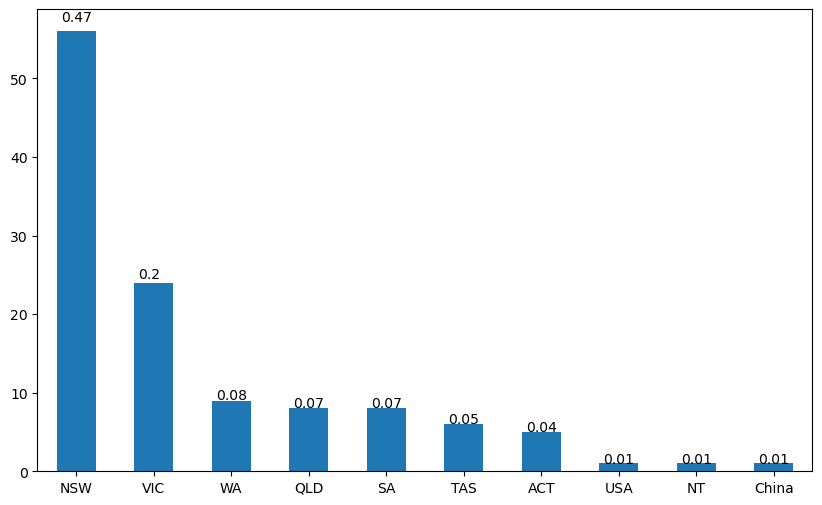

In [333]:
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('QLD') | venues_checked['venue_name'].str.contains('Qld'), 'QLD', np.nan)
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('NT'), 'NT', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('ACT'), 'ACT', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('Sydney') | venues_checked['venue_name'].str.contains('NSW'), 'NSW', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains(' SA') | venues_checked['venue_name'].str.contains('South Australia'), 'SA', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('WA'), 'WA', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('VIC') | venues_checked['venue_name'].str.contains('Vic'),'VIC', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('Tas') | venues_checked['venue_name'].str.contains('TAS'),'TAS', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('USA'), 'USA', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('China'), 'China', venues_checked['State'])
venues_checked['State'] = np.where(venues_checked['venue_name'].str.contains('Griffith'), 'QLD', venues_checked['State'])

# create bar plot
ax = venues_checked['State'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0) # rotate x-labels
for p in ax.patches: ax.annotate(str(round(p.get_height()/len(venues_checked), 2)), (p.get_x() + 0.05, p.get_height() * 1.0225))
plt.show()

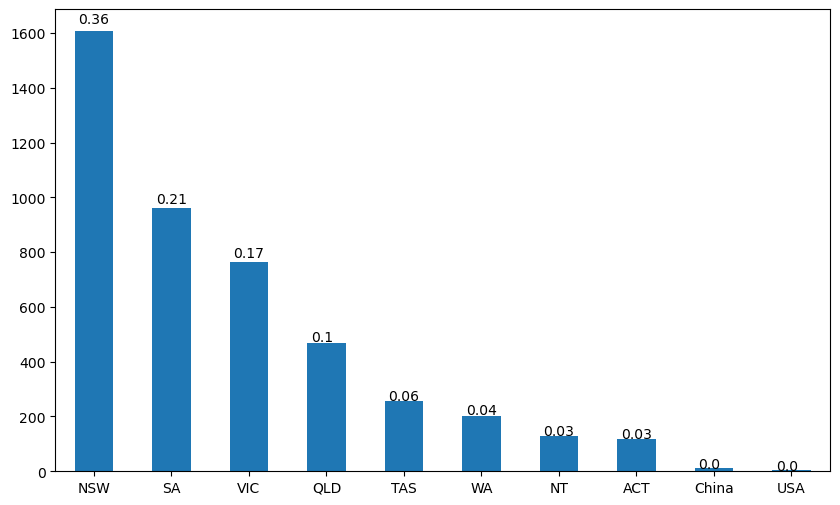

In [335]:
# change address_prompt two match xlsx
clean_data_v2.loc[clean_data_v2.address_prompt.str.contains('321 Blaxland Rd Wentworth Falls'), 'address_prompt'] = '321 Blaxland Rd Wentworth Falls, Sydney'
clean_data_v2.loc[clean_data_v2.address_prompt.str.contains('282 Petrie Terrace'), 'address_prompt'] = '282 Petrie Terrace, Brisbane QLD'

# merge venues_checked with clean_data_v2
clean_data_v2 = clean_data_v2.merge(venues_checked, how='left', left_on='address_prompt', right_on='venue_name')

# add proportions to bar plot
ax = clean_data_v2['State'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0) # rotate x-labels

for p in ax.patches:
    ax.annotate(str(round(p.get_height()/len(clean_data_v2), 2)), (p.get_x() + 0.05, p.get_height() * 1.019))

plt.show()

## Most frequent terms used for place names

From here, we explore the most frequent terms used for place names. We find that the most frequent terms are "Gallery", "Art", "Centre", "Museum", and "University".

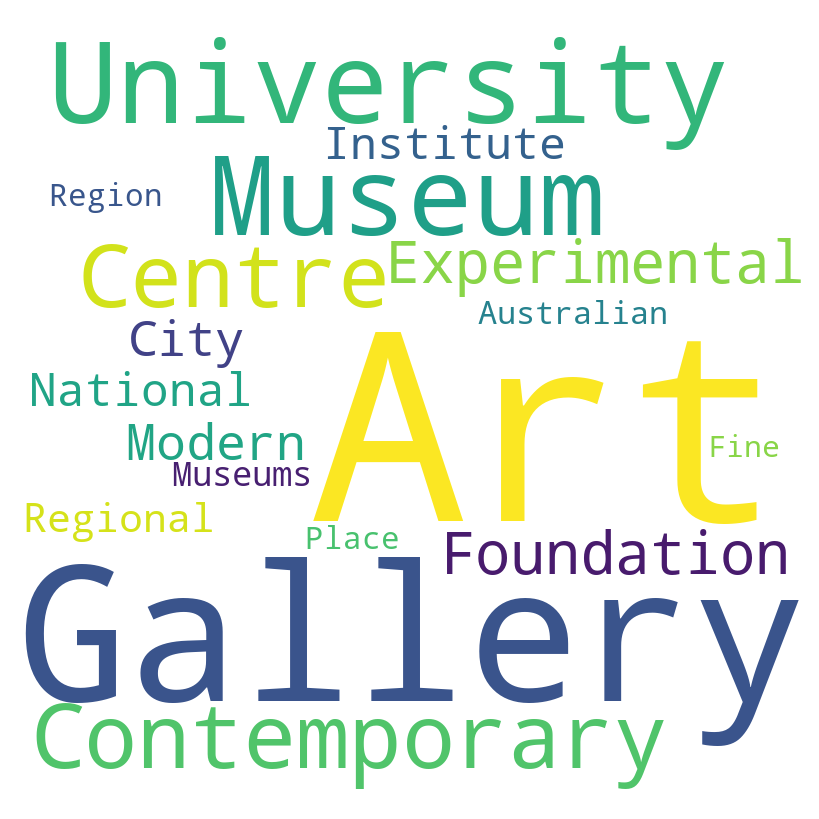

In [382]:
# find the most frequent words across the strings for place names
from collections import Counter
import matplotlib.pyplot as plt

import nltk
# nltk.download('punkt')

from nltk.tokenize import word_tokenize

# create a list of all the place names
all_place_names = clean_data_v2['address_prompt'].astype(str).tolist()

# create a list of all the words in the place names
all_words = []
for place_name in all_place_names:
    all_words.extend(word_tokenize(place_name))

# find top 100 most frequent words
most_freq_words = Counter(all_words).most_common(1000)

# remove a list of all words that are not relevant
words_to_remove = [',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
                   '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
                   'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
                   'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
                   'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
                   'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
                   '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central','Tamar',
                   'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide','Tasmanian','Sherman','Campbelltown']

# remove the words from the list of most frequent words
most_freq_words = [word for word in most_freq_words if word[0] not in words_to_remove]

most_freq_words_dict = dict(most_freq_words)
# keep words in most_freq_words_dict with at least 50 occurrences
most_freq_words_dict = {k: v for k, v in most_freq_words_dict.items() if v > 50}

# add value of two keys
most_freq_words_dict['Gallery'] = most_freq_words_dict['Gallery'] + most_freq_words_dict['Galleries']
# most_freq_words_dict['Museum'] = most_freq_words_dict['Museum'] + most_freq_words_dict['Museums']

# remove key 'Gallery'
most_freq_words_dict.pop('Galleries')
# most_freq_words_dict.pop('Museums')
most_freq_words_dict2 = most_freq_words_dict.copy()

# create a wordcloud with the most frequent words
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(most_freq_words_dict)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Hierarchical clustering using event description data 

Next we explore exhibition descriptions using hierarchical clustering; a method used to group similar objects into clusters that follow a hierarchical structure. This can help conceptualise what a taxonomy of venue categories might look like. We use Google's BERT to embed the data.

### Hierarchical clustering - data pre-processing

In [10]:
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

### collect all relevant textual data from the dataframe
# if description is not \n then append to slug2 in one line
clean_data_v2['slug2'] = clean_data_v2['title'].fillna('') + clean_data_v2['description'].apply(lambda x: '' if x == '\n' else x)

### pre-process for NLP
# Load the documents and their corresponding categorical variables into a Pandas dataframe
df = pd.DataFrame({'text': clean_data_v2['slug2'], 'category': clean_data_v2['address_prompt']})

# summarise text for each unique place name
df['text'] = df.groupby('category')['text'].transform(lambda x: ' '.join(x))

#add new column with count for each category
df['cat_count'] = df.groupby('category')['category'].transform('count')
df.drop_duplicates(inplace=True)

# Clean the text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.replace(',', '')
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

df = df[df['text'].notnull()]
df['clean_text'] = df['text'].apply(clean_text)

### Generate clusters

def get_most_common_word(df, more_words = [], no_of_words=25):
    # remove a list of all words that are not relevant
    # words_to_remove = [',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
    #                 '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
    #                 'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
    #                 'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
    #                 'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
    #                 'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
    #                 '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
    #                 'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide','Place','Vic.',]
    
    words_to_remove = []
    
    # add more words to the list of words to remove
    words_to_remove = words_to_remove + more_words

    all_words = []
    for i in df:
        for j in i.split(' '):
            all_words.append(j.replace(',',''))

    # find the most common words
    most_common_words = Counter(all_words).most_common(no_of_words)

    # remove the words from the list of most frequent words
    most_common_words = [word for word in most_common_words if word[0] not in words_to_remove]
    return most_common_words

def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

### Hierarchical clustering (BERT)

We repeat the methodology but now change the embedding method to BERT. We expect using BERT, a much more complex model, to better represent each venue. We find that the clusters are more widely populated, and output a different outcome.

In [13]:
# ### load bert model

# # !pip install transformers
# from transformers import BertTokenizer, BertModel
# from transformers import pipeline
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

# ### encode text using bert (takes 15 seconds to run)
# import random

# # encode the text using bert
# def bert_encode(x):
#   encoded_input = tokenizer(x, return_tensors='pt')
#   output = model(**encoded_input)
#   return pd.DataFrame(output['pooler_output'].detach().numpy()).T

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df['clean_text_sampled'] = df['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 300)) if len(x.split(' ')) >= 300 else x)
# X_bert = df['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert = model_bert.fit(np.array(X_bert))

# # save model as pickle
# pickle.dump(model_bert, open('models/model_bert.pkl', 'wb'))

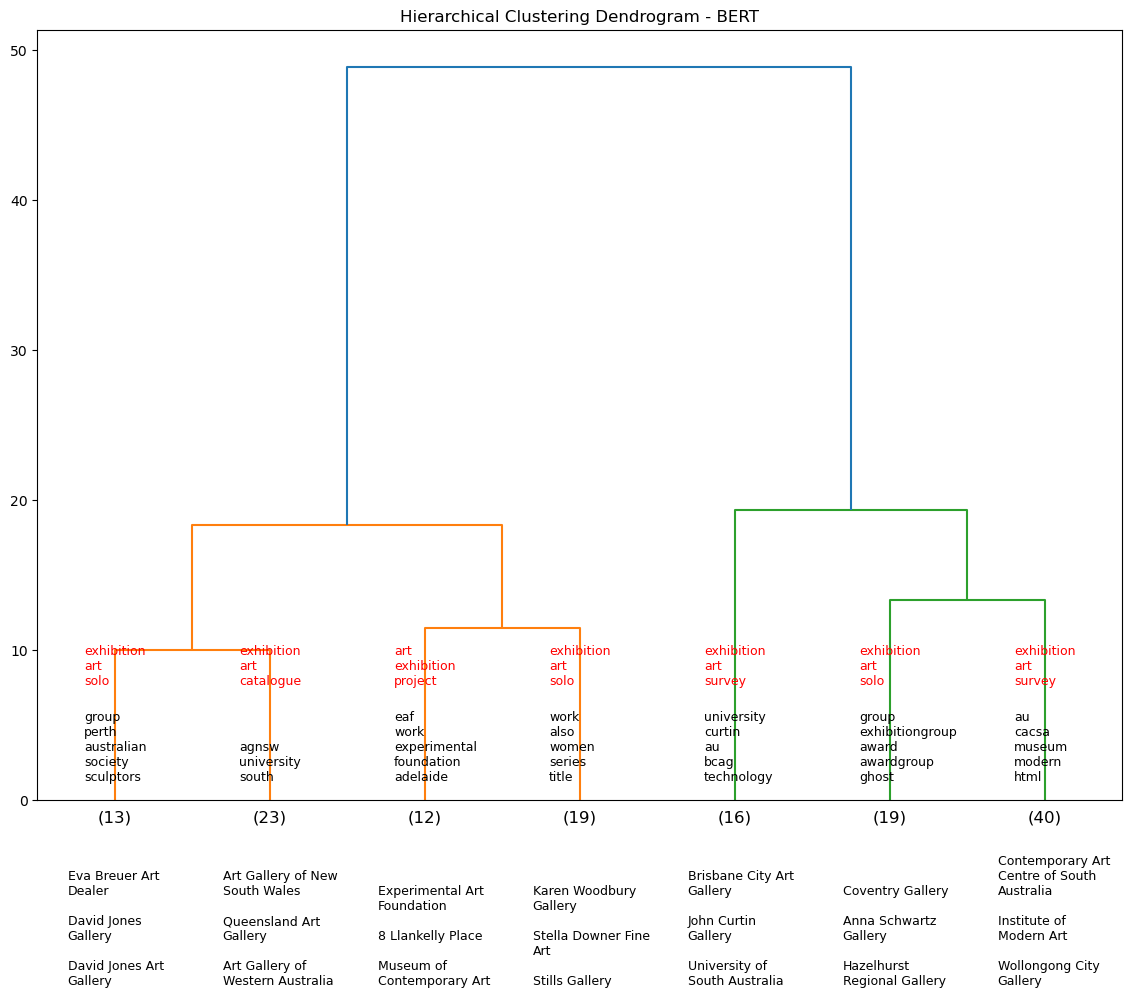

In [11]:
from textwrap import wrap

# read model from pickle
import pickle
model_bert = pickle.load(open('models/model_bert.pkl', 'rb'))

# if a word is a duplicate then remove from all_words
def find_duplicates(all_words, occurences=1):
    duplicates = []
    non_duplicates = []

    for i in all_words:
        if i in duplicates: continue
        else:
            if all_words.count(i) > occurences: duplicates.append(i)
            else: non_duplicates.append(i)
    return duplicates

cut = 7
l_matrix = get_linkage_matrix(model_bert)
df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

all_words = []

for i in df['cluster'].unique():
    cluster_docs = df[df['cluster'] == i]
    # print(i, get_most_common_word(cluster_docs['clean_text']))

    annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
    
    plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.15), 
                 xytext=(i/df['cluster'].nunique()-0.1, 0.15), 
                 xycoords='axes fraction', fontsize=9, color='red')

    [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
all_words_to_remove = find_duplicates(all_words, occurences=2)
all_words_to_remove.extend(['j','th','nd','exhibitionexhibited','http','www','isbn'])

for i in df['cluster'].unique():
    cluster_docs = df[df['cluster'] == i]
    # print(i, get_most_common_word(cluster_docs['clean_text']))
    annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
                                                                       more_words=all_words_to_remove)) if (idx < 5))
    
    plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.025), 
                 xytext=(i/df['cluster'].nunique()-0.1, 0.025), 
                 xycoords='axes fraction', fontsize=9)
    
    annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
    annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
    # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

    plt.annotate(annot2, xy=(i/df['cluster'].nunique()-0.115, -0.24), 
                xytext=(i/df['cluster'].nunique()-0.115, -0.24), 
                xycoords='axes fraction', fontsize=9)

plt.title("Hierarchical Clustering Dendrogram - BERT")

# make figure bigger
fig = plt.gcf()
fig.set_size_inches(14, 10)

plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_bert.png', dpi=300, bbox_inches='tight')

# from IPython.display import Image
# Image(filename='images/daao_tlc/outputnew_bert.png')

# # df to xlsx
# df.to_excel('data/142_venues_v1.xlsx', index=False)

We provide the same visual however show the most frequent terms used within the place names as opposed to the event descriptions.

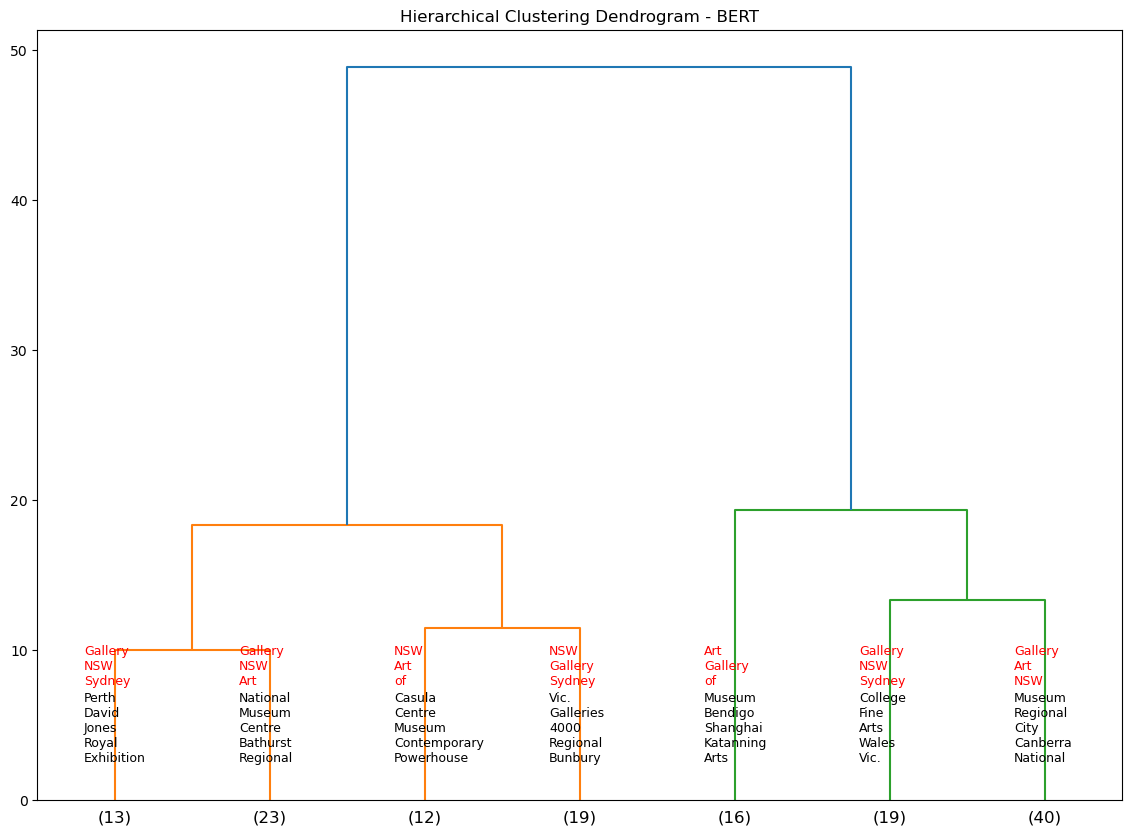

In [14]:
cut = 7
l_matrix = get_linkage_matrix(model_bert)
df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

all_words = []

for i in df['cluster'].unique():
    cluster_docs = df[df['cluster'] == i]
    # print(i, get_most_common_word(cluster_docs['clean_text']))

    annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'])) if (idx < 3))
    
    plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.15), 
                 xytext=(i/df['cluster'].nunique()-0.1, 0.15), 
                 xycoords='axes fraction', fontsize=9, color='red')
    
    [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=25))]
    
all_words_to_remove = find_duplicates(all_words, occurences=4)
all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
                   '.', 'New', 'Australia', 'QLD', 'Vic','and','WA','Victoria','ACT','Qld',
                   'of','Wollongong','TAS','Queensland','Newcastle',
                   'Street','Hobart','the','The','Launceston','Orange','NT',
                   'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
                   'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
                   '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
                   'Curtin','France','Tin','Sheds','York','Monash','Heide',''])

for i in df['cluster'].unique():
    cluster_docs = df[df['cluster'] == i]
    # print(i, get_most_common_word(cluster_docs['clean_text']))
    annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
                                                                       more_words=all_words_to_remove)) if (idx < 5))
    
    plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
                 xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
                 xycoords='axes fraction', fontsize=9)

plt.title("Hierarchical Clustering Dendrogram - BERT")

# make figure bigger
fig = plt.gcf()
fig.set_size_inches(14, 10)

plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_bert_placename.png', dpi=300, bbox_inches='tight')

# from IPython.display import Image
# Image(filename='images/daao_tlc/outputnew_bert_placename.png')

### Hierarchy Clustering - BERT by demi-decade

Using the BERT model, we generate a series of dendrograms that show the hierarchical clustering of the exhibition descriptions by 5-year periods. We omit pre-1970s data as there is not enough data to generate a meaningful dendrogram for each demi-decade (see table output below).

In [15]:
clean_data_v2['decade_start'].value_counts().sort_index().reset_index().rename(columns={'index':'decade_start', 'decade_start':'count'}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
decade_start,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
count,7,6,4,5,13,35,73,506,1030,1464,1064,207,1


Top ten place names and year

In [16]:
clean_data_v2[['start_year','address_prompt']].value_counts().head(10)

start_year  address_prompt                                          
1983.0      Experimental Art Foundation, Adelaide, SA                   45
1982.0      Experimental Art Foundation, Adelaide, SA                   30
1979.0      Contemporary Art Centre of South Australia, Adelaide, SA    25
1978.0      Contemporary Art Centre of South Australia, Adelaide, SA    23
1986.0      Experimental Art Foundation, Adelaide, SA                   23
1979.0      Experimental Art Foundation, Adelaide, SA                   22
1997.0      Experimental Art Foundation, Adelaide, SA                   22
1976.0      Experimental Art Foundation, Adelaide, SA                   22
1985.0      Experimental Art Foundation, Adelaide, SA                   22
1981.0      Experimental Art Foundation, Adelaide, SA                   20
dtype: int64

Top ten place names and decade

In [17]:
clean_data_v2[['decade_start','address_prompt']].value_counts().head(10)

decade_start  address_prompt                                                 
1980          Experimental Art Foundation, Adelaide, SA                          199
1970          Contemporary Art Centre of South Australia, Adelaide, SA           110
1980          Contemporary Art Centre of South Australia, Adelaide, SA           105
1990          Experimental Art Foundation, Adelaide, SA                          102
1970          Experimental Art Foundation, Adelaide, SA                           98
1990          Art Gallery of New South Wales, Sydney, NSW                         98
              Contemporary Art Centre of South Australia, Adelaide, SA            97
              Institute of Modern Art, Brisbane, QLD                              95
1980          Museums and Art Galleries of the Northern Territory, Darwin, NT     79
1990          Wollongong City Gallery, Wollongong, NSW                            74
dtype: int64

In [21]:
# def temporal_dendos(startdt=1900, enddt=1920, cut_input=3):
#     df_period = clean_data_v2[(clean_data_v2['start_year'] >= startdt) & (clean_data_v2['start_year'] <= enddt)]
#     # df_period = clean_data_v2[(clean_data_v2['decade_start'] >= startdt) & (clean_data_v2['decade_start'] <= enddt)]
#     ### pre-process for NLP
#     # Load the documents and their corresponding categorical variables into a Pandas dataframe
#     df_period = pd.DataFrame({'text': df_period['slug2'], 'category': df_period['address_prompt']})

#     # summarise text for each unique place name
#     df_period['text'] = df_period.groupby('category')['text'].transform(lambda x: ' '.join(x))

#     #add new column with count for each category
#     df_period['cat_count'] = df_period.groupby('category')['category'].transform('count')
#     df_period.drop_duplicates(inplace=True)

#     # Clean the text
#     stop_words = set(stopwords.words('english'))
#     df_period = df_period[df_period['text'].notnull()]
#     df_period['clean_text'] = df_period['text'].apply(clean_text)

#     # randomly sample 512 tokens from each row in df['clean_text']
#     # some strings are smalle than 512
#     df_period['clean_text_sampled'] = df_period['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 275)) if len(x.split(' ')) >= 275 else x)
#     X_bert_period = df_period['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

#     # setting distance_threshold=0 ensures we compute the full tree.
#     model_bert_period = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
#     model_bert_period = model_bert_period.fit(np.array(X_bert_period))

#     ### generate dendrogram
#     cut = cut_input
#     l_matrix = get_linkage_matrix(model_bert_period)
#     df_period['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
#     dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

#     all_words = []

#     for i in df_period['cluster'].unique():
#         cluster_docs = df_period[df_period['cluster'] == i]
#         # print(i, get_most_common_word(cluster_docs['clean_text']))

#         annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
        
#         plt.annotate(annot, xy=(i/df_period['cluster'].nunique()-0.1, 0.15), 
#                     xytext=(i/df_period['cluster'].nunique()-0.1, 0.15), 
#                     xycoords='axes fraction', fontsize=9, color='red')

#         [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
        
#     all_words_to_remove = find_duplicates(all_words, occurences=2)
#     all_words_to_remove.extend(['j','th','nd','exhibitionexhibited','http','www','isbn'])

#     for i in df_period['cluster'].unique():
#         cluster_docs = df_period[df_period['cluster'] == i]
#         # print(i, get_most_common_word(cluster_docs['clean_text']))
#         annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                         more_words=all_words_to_remove)) if (idx < 5))
        
#         plt.annotate(annot, xy=(i/df_period['cluster'].nunique()-0.1, 0.025), 
#                     xytext=(i/df_period['cluster'].nunique()-0.1, 0.025), 
#                     xycoords='axes fraction', fontsize=9)
        
#         annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#         annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#         # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#         plt.annotate(annot2, xy=(i/df_period['cluster'].nunique()-0.115, -0.24), 
#                     xytext=(i/df_period['cluster'].nunique()-0.115, -0.24), 
#                     xycoords='axes fraction', fontsize=9)

#     plt.title(f"Hierarchical Clustering Dendrogram - BERT - {startdt}-{enddt}")

#     # make figure bigger
#     fig = plt.gcf()
#     fig.set_size_inches(14, 10)

#     plt.show()
#     # return df_period

#     # # save the figure
#     # fig.savefig(f'images/daao_tlc/outputnew_bert_{startdt}_{enddt}.png', dpi=300, bbox_inches='tight')

# temporal_dendos(1900, 1960, cut_input=5)
# temporal_dendos(1960, 1980, cut_input=5)
# temporal_dendos(1980, 2000, cut_input=5)
# temporal_dendos(2000, 2021, cut_input=5)

# # from IPython.display import Image
# # Image(filename='images/daao_tlc/outputnew_bert_1900_1920.png')

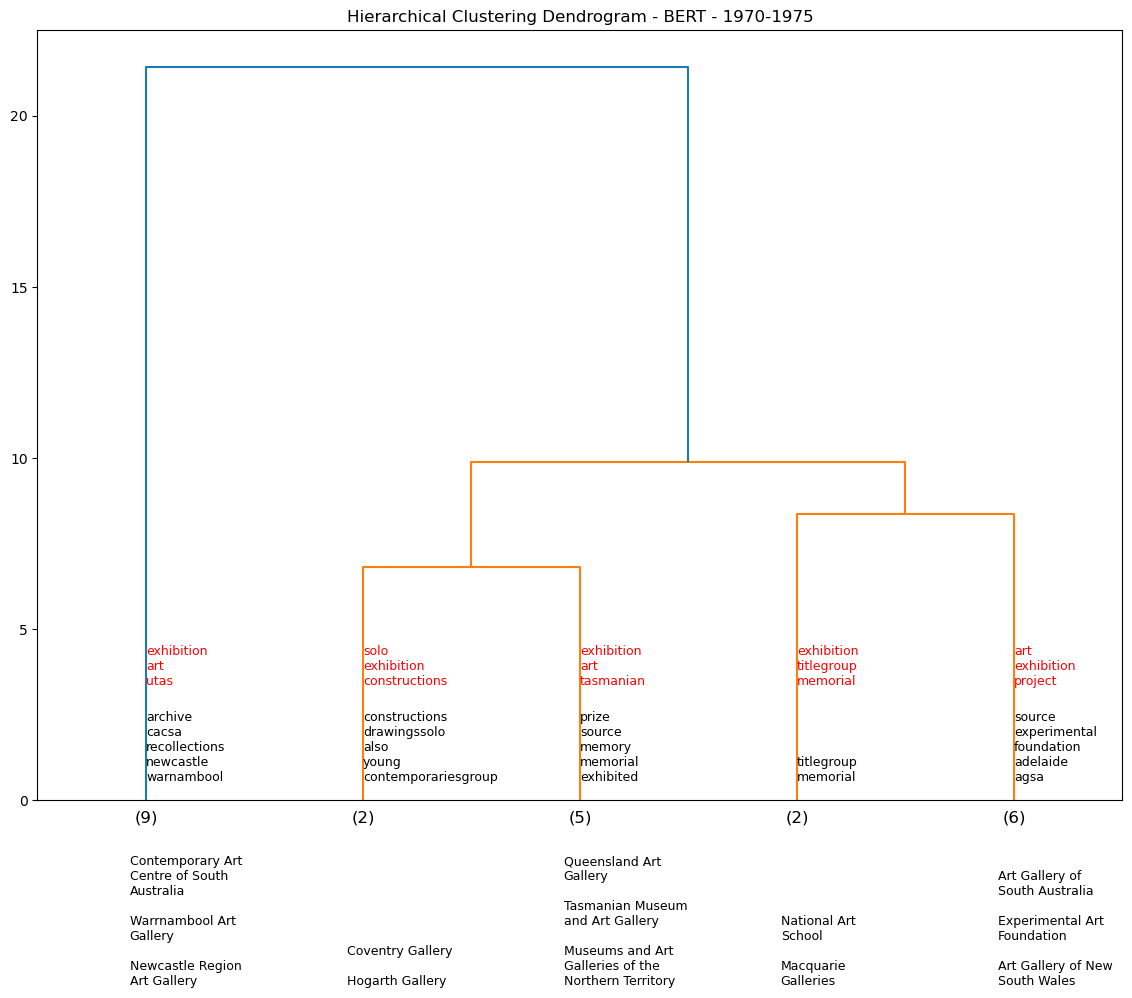

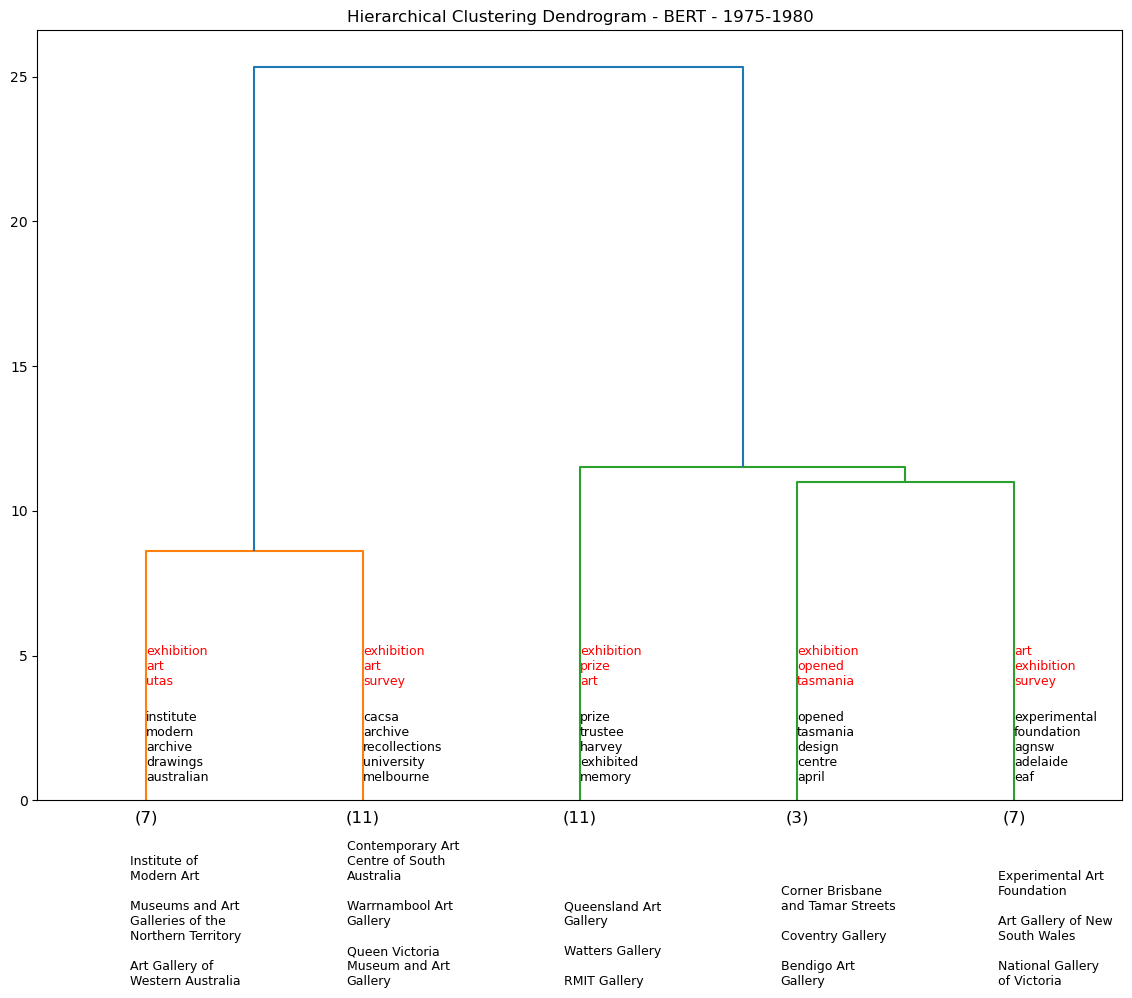

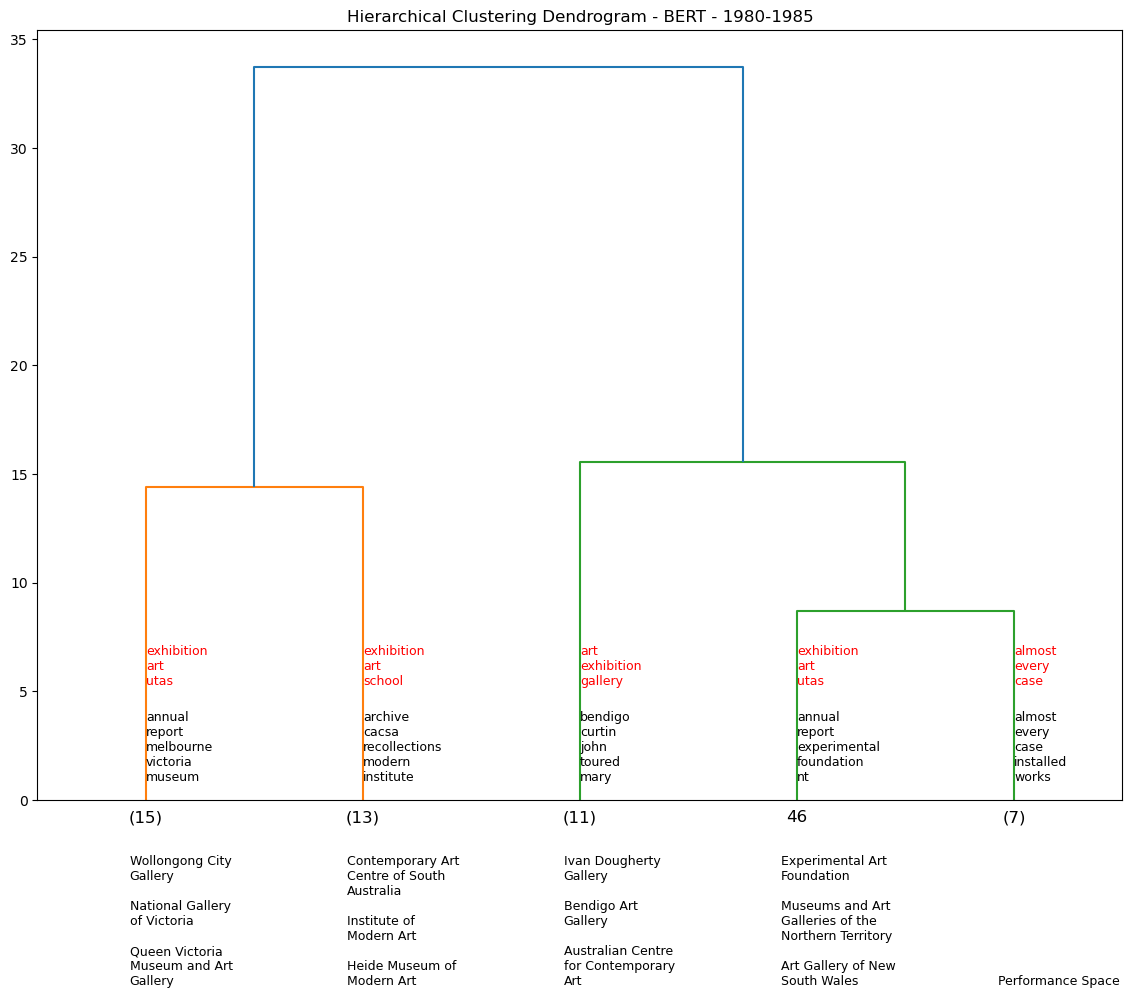

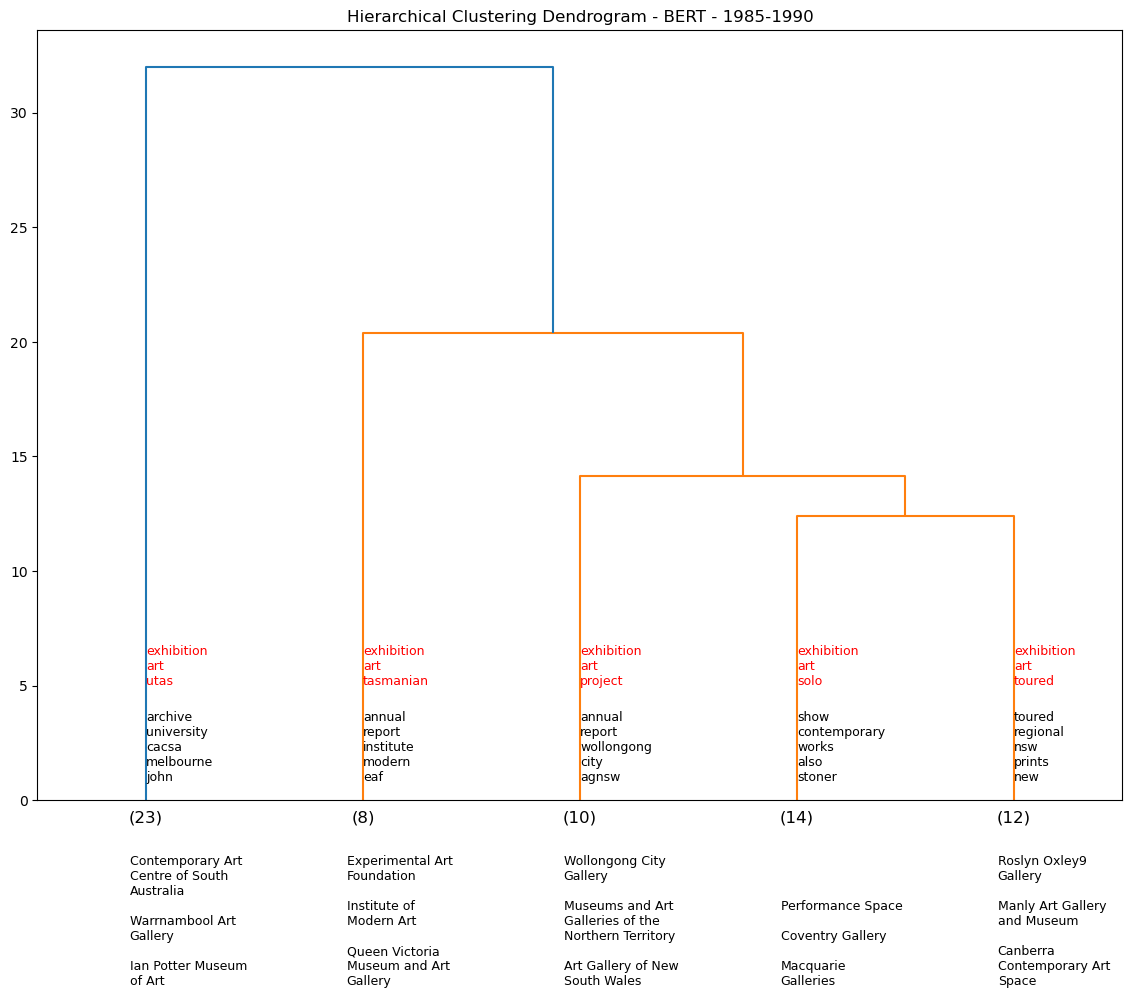

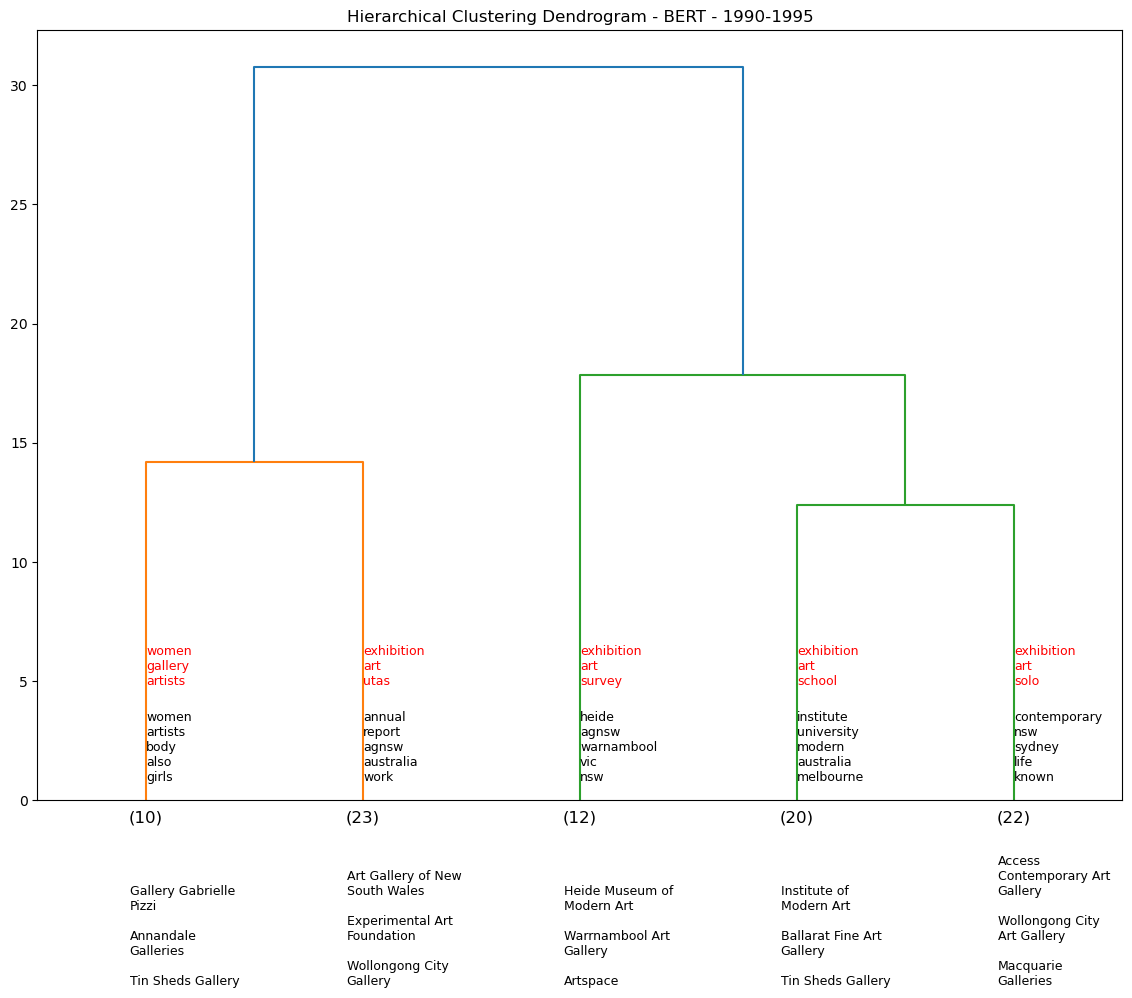

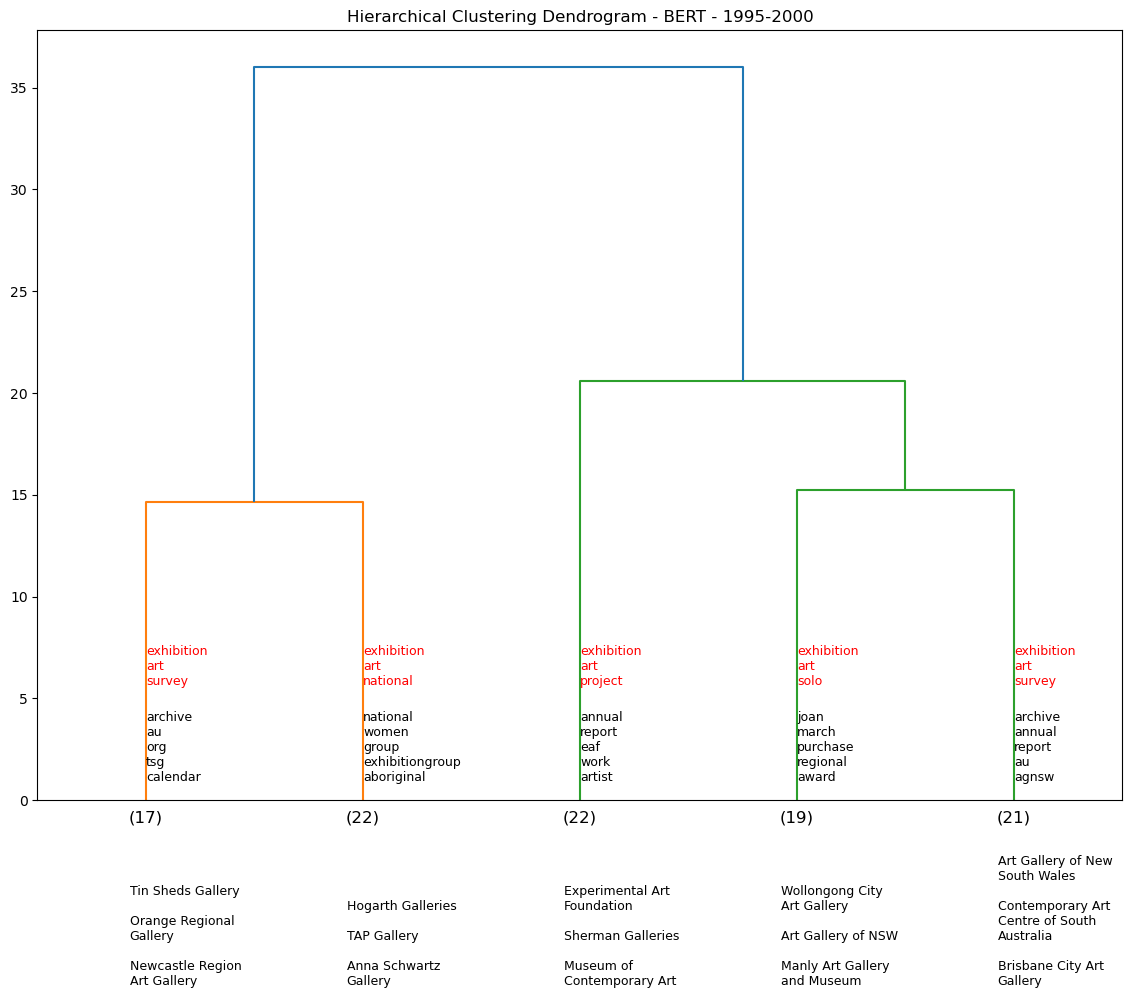

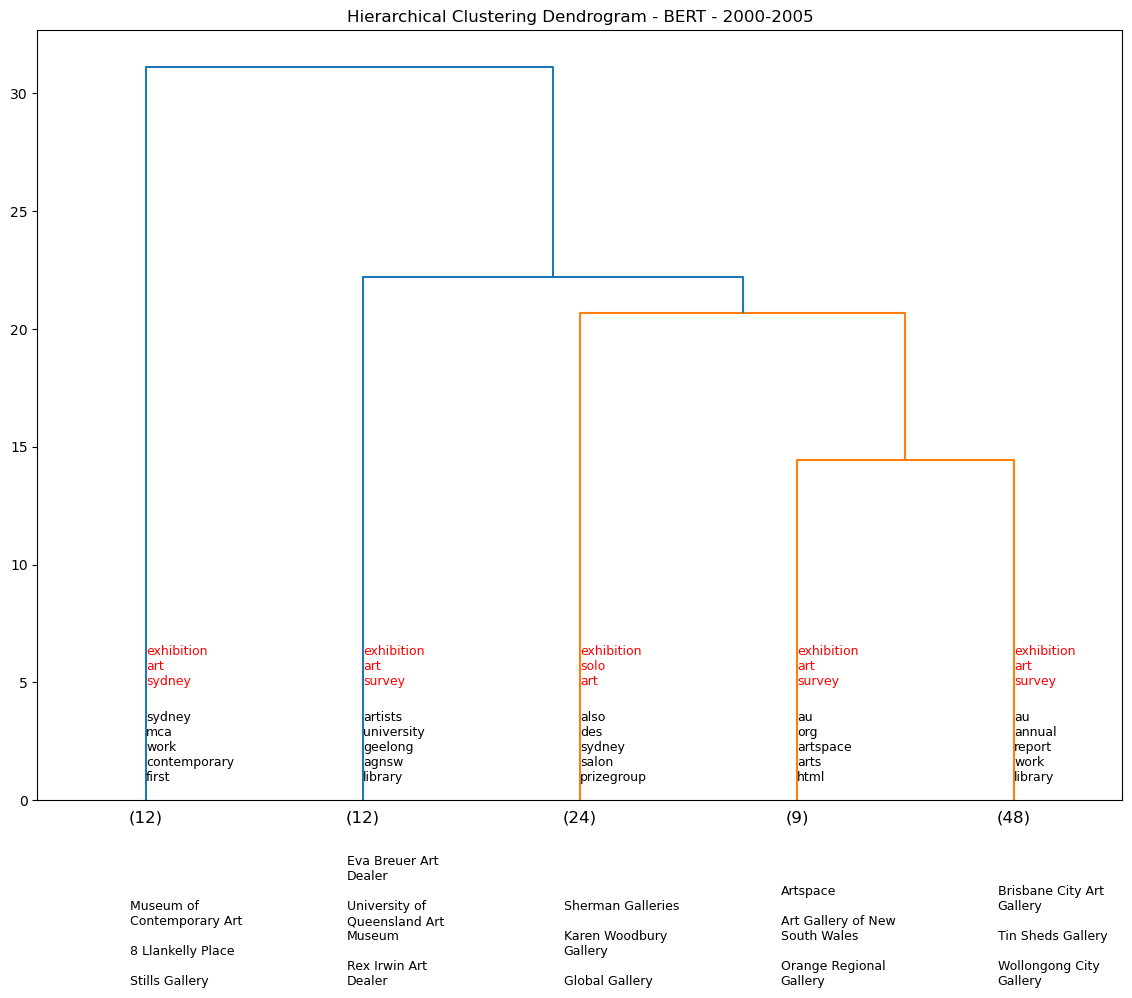

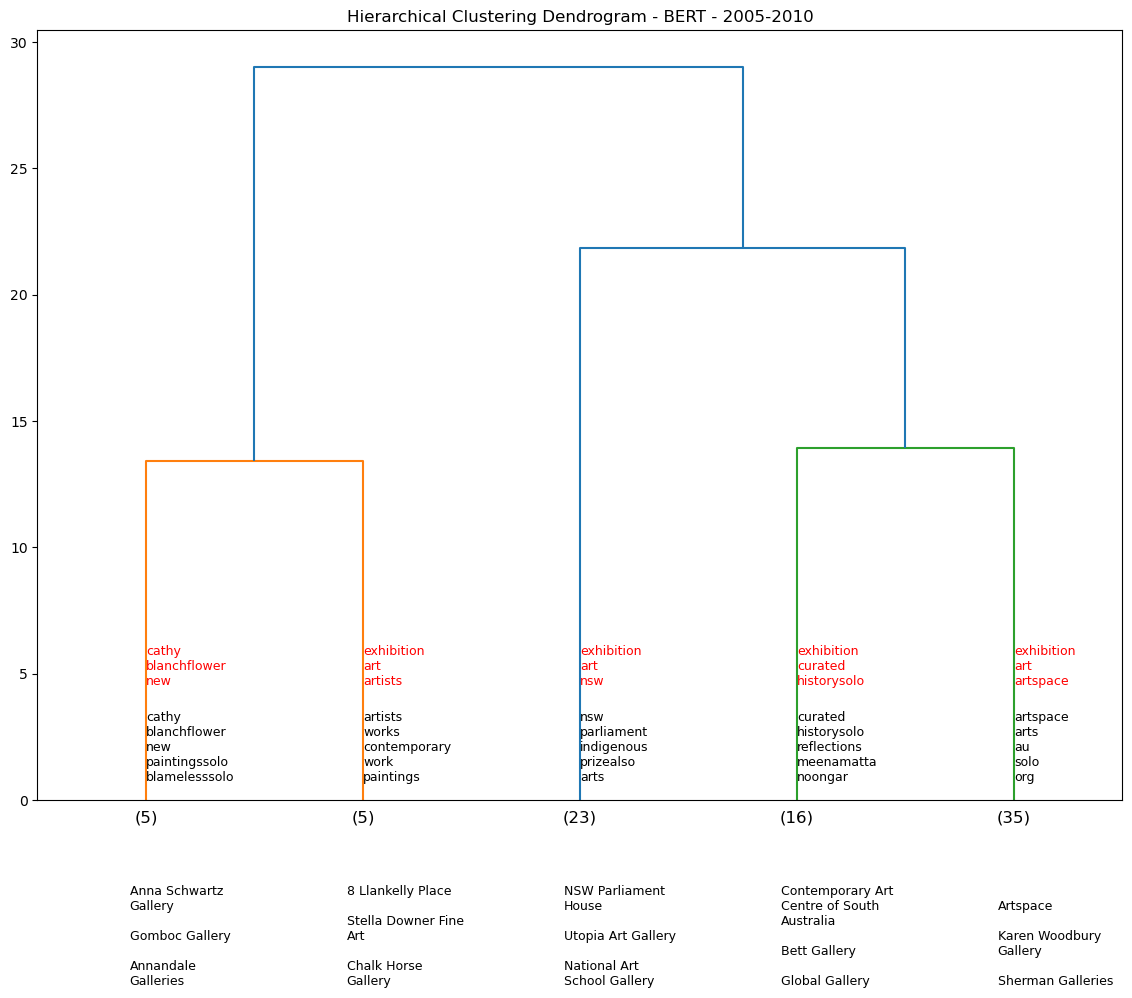

In [20]:
def temporal_dendos(startdt=1900, enddt=1920, cut_input=3, model=None):
    df_period = clean_data_v2[(clean_data_v2['start_year'] >= startdt) & (clean_data_v2['start_year'] <= enddt)]
    # df_period = clean_data_v2[(clean_data_v2['decade_start'] >= startdt) & (clean_data_v2['decade_start'] <= enddt)]
    ### pre-process for NLP
    # Load the documents and their corresponding categorical variables into a Pandas dataframe
    df_period = pd.DataFrame({'text': df_period['slug2'], 'category': df_period['address_prompt']})

    # summarise text for each unique place name
    df_period['text'] = df_period.groupby('category')['text'].transform(lambda x: ' '.join(x))

    #add new column with count for each category
    df_period['cat_count'] = df_period.groupby('category')['category'].transform('count')
    df_period.drop_duplicates(inplace=True)

    # Clean the text
    stop_words = set(stopwords.words('english'))
    df_period = df_period[df_period['text'].notnull()]
    df_period['clean_text'] = df_period['text'].apply(clean_text)

    if model is None:
        # randomly sample 512 tokens from each row in df['clean_text']
        # some strings are smalle than 512
        df_period['clean_text_sampled'] = df_period['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 275)) if len(x.split(' ')) >= 275 else x)
        X_bert_period = df_period['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

        # setting distance_threshold=0 ensures we compute the full tree.
        model_bert_period = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
        model_bert_period = model_bert_period.fit(np.array(X_bert_period))

        # save model as pickle
        pickle.dump(model_bert_period, open(f'models/model_bert_{startdt}_{enddt}.pkl', 'wb'))
    else:
        model_bert_period = pickle.load(open(f'models/model_bert_{startdt}_{enddt}.pkl', 'rb'))

    ### generate dendrogram
    cut = cut_input
    l_matrix = get_linkage_matrix(model_bert_period)
    df_period['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
    dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

    all_words = []

    for i in df_period['cluster'].unique():
        cluster_docs = df_period[df_period['cluster'] == i]
        # print(i, get_most_common_word(cluster_docs['clean_text']))

        annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
        
        plt.annotate(annot, xy=(i/df_period['cluster'].nunique()-0.1, 0.15), 
                    xytext=(i/df_period['cluster'].nunique()-0.1, 0.15), 
                    xycoords='axes fraction', fontsize=9, color='red')

        [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
        
    all_words_to_remove = find_duplicates(all_words, occurences=2)
    all_words_to_remove.extend(['j','th','nd','exhibitionexhibited','http','www','isbn'])

    for i in df_period['cluster'].unique():
        cluster_docs = df_period[df_period['cluster'] == i]
        # print(i, get_most_common_word(cluster_docs['clean_text']))
        annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
                                                                        more_words=all_words_to_remove)) if (idx < 5))
        
        plt.annotate(annot, xy=(i/df_period['cluster'].nunique()-0.1, 0.025), 
                    xytext=(i/df_period['cluster'].nunique()-0.1, 0.025), 
                    xycoords='axes fraction', fontsize=9)
        
        annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
        annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
        # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

        plt.annotate(annot2, xy=(i/df_period['cluster'].nunique()-0.115, -0.24), 
                    xytext=(i/df_period['cluster'].nunique()-0.115, -0.24), 
                    xycoords='axes fraction', fontsize=9)

    plt.title(f"Hierarchical Clustering Dendrogram - BERT - {startdt}-{enddt}")

    # make figure bigger
    fig = plt.gcf()
    fig.set_size_inches(14, 10)

    plt.show()
    return df_period

# from IPython.display import Image
# Image(filename='images/daao_tlc/outputnew_bert_1920_1940.png')

df_70_75 = temporal_dendos(1970, 1975, cut_input=5, model=0)
df_75_80 = temporal_dendos(1975, 1980, cut_input=5, model=0)
df_80_85 = temporal_dendos(1980, 1985, cut_input=5, model=0)
df_85_90 = temporal_dendos(1985, 1990, cut_input=5, model=0)
df_90_95 = temporal_dendos(1990, 1995, cut_input=5, model=0)
df_95_00 = temporal_dendos(1995, 2000, cut_input=5, model=0)
df_00_05 = temporal_dendos(2000, 2005, cut_input=5, model=0)
df_05_10 = temporal_dendos(2005, 2010, cut_input=5, model=0)

#### National Gallery of Victoria, Melbourne, VIC

We assess five venues and their associated clusters to see if they are any consistent venue pairings. For example over the dndrograms above, NGV is clustered with Wollongong City Gallery five times out of a potential eight temporal iterations. We see a similar pattern for Ballarat Fine Art Gallery and Queen Victoria Museum and Art Gallery.

In [24]:
def try_merge(df1, df2, venue):
    try: return pd.concat([df1, df2[df2['cluster'] == df2[df2['category'] == venue]['cluster'].values[0]]])
    except: return df1


df_test = pd.DataFrame()
venue = 'National Gallery of Victoria, Melbourne, VIC'
df_test = try_merge(df_test, df_70_75, venue)
df_test = try_merge(df_test, df_75_80, venue)
df_test = try_merge(df_test, df_80_85, venue)
df_test = try_merge(df_test, df_85_90, venue)
df_test = try_merge(df_test, df_90_95, venue)
df_test = try_merge(df_test, df_95_00, venue)
df_test = try_merge(df_test, df_00_05, venue)
df_test = try_merge(df_test, df_05_10, venue)
print(df_test['category'].value_counts().head(6).tail(-1))


Wollongong City Gallery, Wollongong, NSW                  5
Ballarat Fine Art Gallery, Ballarat, VIC                  5
Queen Victoria Museum and Art Gallery, Launceston, TAS    5
Warrnambool Art Gallery, Warrnambool, VIC                 4
Australian Centre for Contemporary Art, Melbourne, VIC    4
Name: category, dtype: int64


#### Experimental Art Foundation, Adelaide, SA

In [26]:
df_test = pd.DataFrame()
venue = 'Experimental Art Foundation, Adelaide, SA'
df_test = try_merge(df_test, df_70_75, venue)
df_test = try_merge(df_test, df_75_80, venue)
df_test = try_merge(df_test, df_80_85, venue)
df_test = try_merge(df_test, df_85_90, venue)
df_test = try_merge(df_test, df_90_95, venue)
df_test = try_merge(df_test, df_95_00, venue)
df_test = try_merge(df_test, df_00_05, venue)
df_test = try_merge(df_test, df_05_10, venue)
print(df_test['category'].value_counts().head(6).tail(-1))

Art Gallery of New South Wales, Sydney, NSW           5
Queensland Art Gallery, Brisbane, QLD                 4
Art Gallery of Western Australia, Perth, WA           4
Corner Brisbane and Tamar Streets, Launceston, TAS    3
Art Gallery of South Australia, Adelaide, SA          3
Name: category, dtype: int64


#### Contemporary Art Centre of South Australia, Adelaide, SA

In [27]:
df_test = pd.DataFrame()
venue = 'Contemporary Art Centre of South Australia, Adelaide, SA'
df_test = try_merge(df_test, df_70_75, venue)
df_test = try_merge(df_test, df_75_80, venue)
df_test = try_merge(df_test, df_80_85, venue)
df_test = try_merge(df_test, df_85_90, venue)
df_test = try_merge(df_test, df_90_95, venue)
df_test = try_merge(df_test, df_95_00, venue)
df_test = try_merge(df_test, df_00_05, venue)
df_test = try_merge(df_test, df_05_10, venue)
print(df_test['category'].value_counts().head(6).tail(-1))

Monash University Museum of Art, Melbourne, VIC    5
Newcastle Region Art Gallery, Newcastle, NSW       5
National Gallery of Victoria, Melbourne, VIC       4
Heide Museum of Modern Art, Melbourne, VIC         4
Warrnambool Art Gallery, Warrnambool, VIC          4
Name: category, dtype: int64


#### Art Gallery of New South Wales, Sydney, NSW

In [28]:
df_test = pd.DataFrame()
venue = 'Art Gallery of New South Wales, Sydney, NSW'
df_test = try_merge(df_test, df_70_75, venue)
df_test = try_merge(df_test, df_75_80, venue)
df_test = try_merge(df_test, df_80_85, venue)
df_test = try_merge(df_test, df_85_90, venue)
df_test = try_merge(df_test, df_90_95, venue)
df_test = try_merge(df_test, df_95_00, venue)
df_test = try_merge(df_test, df_00_05, venue)
df_test = try_merge(df_test, df_05_10, venue)
print(df_test['category'].value_counts().head(6).tail(-1))


Experimental Art Foundation, Adelaide, SA                          5
Wollongong City Gallery, Wollongong, NSW                           4
National Gallery of Victoria, Melbourne, VIC                       4
Museums and Art Galleries of the Northern Territory, Darwin, NT    4
Art Gallery of South Australia, Adelaide, SA                       3
Name: category, dtype: int64


#### Wollongong City Gallery, Wollongong, NSW

In [31]:
df_test = pd.DataFrame()
venue = 'Wollongong City Gallery, Wollongong, NSW'
df_test = try_merge(df_test, df_70_75, venue)
df_test = try_merge(df_test, df_75_80, venue)
df_test = try_merge(df_test, df_80_85, venue)
df_test = try_merge(df_test, df_85_90, venue)
df_test = try_merge(df_test, df_90_95, venue)
df_test = try_merge(df_test, df_95_00, venue)
df_test = try_merge(df_test, df_00_05, venue)
df_test = try_merge(df_test, df_05_10, venue)
print(df_test['category'].value_counts().head(6).tail(-1))

Warrnambool Art Gallery, Warrnambool, VIC                 5
Queen Victoria Museum and Art Gallery, Launceston, TAS    5
National Gallery of Victoria, Melbourne, VIC              5
Tasmanian Museum and Art Gallery, Hobart, TAS             4
Ballarat Fine Art Gallery, Ballarat, VIC                  4
Name: category, dtype: int64


## Organisations
Similar to venues, we first produce a word cloud for common terms used in organisation names. We find that the most frequent terms are "Society", "Art", "Gallery", "Royal", and "Arts".

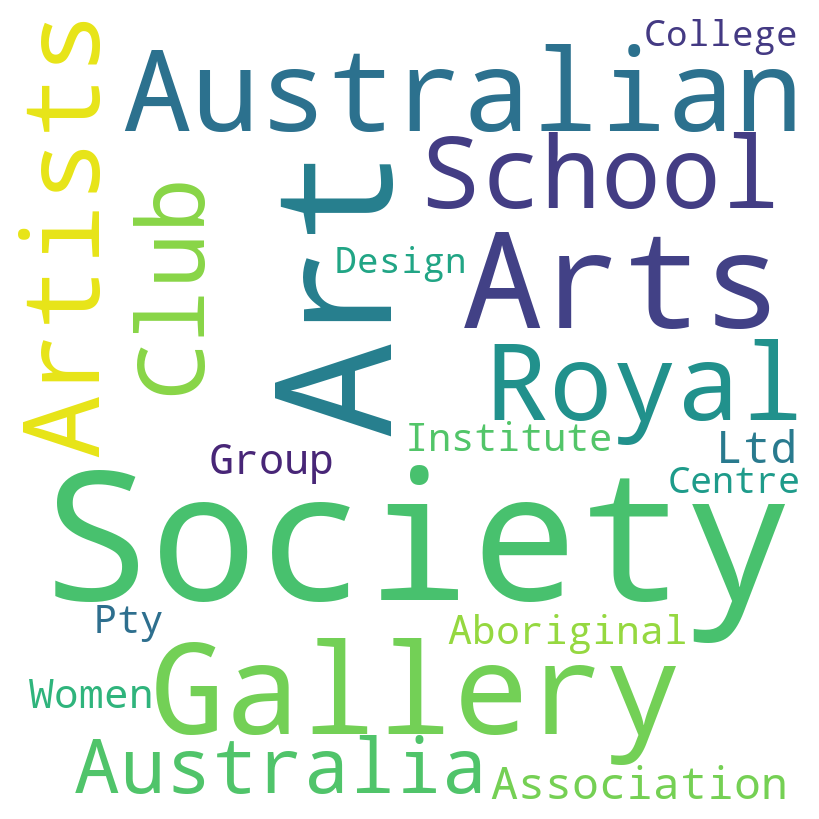

In [32]:
# bios = pd.read_csv('data/daao_biography_level_202202211719.csv')
# bios = bios[['_id','primary_name.family_name','primary_name.given_names']]
# bios[bios['_id'].str.contains('4e1e1424b846f2dae7001dc0')]

with open("data/daao_persongroup_level.json") as json_file: daoo_org_data=json.load(json_file)

# create a list of all the place names
all_place_names = pd.json_normalize(daoo_org_data)['primary_name'].astype(str).tolist()

# create a list of all the words in the place names
all_words = []
for place_name in all_place_names:
    all_words.extend(word_tokenize(place_name))

# find top 100 most frequent words
most_freq_words = Counter(all_words).most_common(40)

# remove a list of all words that are not relevant
words_to_remove = [',','.','and','of','the','The','for',"'s",'&','(',')','J.','Melbourne',
                   'UK','VIC','London',
                   'Jane','Lapham','*','Adelaide',"'",'Sydney','NSW','New','South','Wales']

# remove the words from the list of most frequent words
most_freq_words = [word for word in most_freq_words if word[0] not in words_to_remove]

most_freq_words_dict = dict(most_freq_words)

# # add value of two keys
# most_freq_words_dict['Gallery'] = most_freq_words_dict['Gallery'] + most_freq_words_dict['Galleries']
# most_freq_words_dict['Museum'] = most_freq_words_dict['Museum'] + most_freq_words_dict['Museums']

# # remove key 'Gallery'
# most_freq_words_dict.pop('Galleries')
# most_freq_words_dict.pop('Museums')

# create a wordcloud with the most frequent words
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(most_freq_words_dict)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

As shown above, the use of dendrograms can be an interesting exercise to explore the data. The initial idea was to repeat the same approach with organisations to assess any latent patterns through this taxonomic approrach. However, we find that the data is not as rich as the venue data and that there are many organisations with no biographies, no summaries, and no relations to people records, exhibition records, etc.  Nevertheless we provide one dendrogram using organisation biographies.

Below is a list of the proportion of missing data for each field across DAAO organisations.

In [33]:
# find the proportion of null values in each column
print((pd.json_normalize(daoo_org_data).isnull().sum()/pd.json_normalize(daoo_org_data).shape[0])[0:20])

biography              0.869957
_cls                   0.000000
editing_complete       0.922318
is_deleted             0.000000
is_featured            0.000000
is_locked              0.000000
is_primary             0.000000
is_shadow              0.000000
primary_name           0.000858
periods_active         0.959227
record_status          0.000000
residences             0.959442
roles                  0.000000
sources                0.913519
slug                   0.000000
summary                0.917167
related_stub_people    0.998927
_id.$oid               0.000000
date_created.$date     0.024678
date_modified.$date    0.069528
dtype: float64


In [34]:
print((pd.json_normalize(daoo_org_data).isnull().sum()/pd.json_normalize(daoo_org_data).shape[0])[20:])

references                    0.896567
tags                          0.962017
type                          0.974464
types                         0.965665
related_events                0.972318
related_collections           0.985837
related_works                 0.922318
related_recognitions          0.996996
related_stub_person_groups    0.998927
copyright_agents              0.999571
urls                          0.896137
alternative_names             0.967811
locked_biographies            0.999356
other_occupations             0.996996
see_alsos                     0.982833
nla_id                        0.999356
source_database_ids           0.985837
dtype: float64


In [ ]:
# from bs4 import BeautifulSoup

# orgs = pd.DataFrame(columns=['name','summary','bio'])

# # pd.json_normalize(daoo_org_data)['biography'].isnull().sum()/pd.json_normalize(daoo_org_data).shape[0] # 87% of rows have no biography

# for i,row in pd.json_normalize(daoo_org_data).iterrows():
#     try:
#         try: row['biography'][0]['text']
#         except: continue

#         # try: period_start = row['periods_active'][0]['start']['_date']
#         # except: period_start = None

#         # try: period_end = row['periods_active'][0]['end']['_date']
#         # except: period_end = None

#         # use pandas.concat to append new row to dataframe
#         orgs = pd.concat([orgs, pd.DataFrame({'name': [row['primary_name']],
#                                                 'summary': [row['summary']],
#                                                 'bio': [row['biography'][0]['text']],
#                                                 # 'period_start': [period_start],
#                                                 # 'period_end': [period_end]
#                                                 })], ignore_index=True)
        
#     except:
#         print(i)
#         break

# # remove empty summary
# orgs['summary'].fillna('', inplace=True)

# # remove rows with stub text
# orgs = orgs[~orgs['bio'].isin(orgs['bio'].value_counts().head(5).index.to_list())]

# # combine summary and bio
# orgs['bio'] = orgs['summary'] + orgs['bio'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

# orgs = orgs[['name','bio']]

In [ ]:
# ### encode text using bert (takes 4mins to run)

# ### pre-process for NLP
# # Load the documents and their corresponding categorical variables into a Pandas dataframe
# df_org = pd.DataFrame({'text': orgs['bio'], 'category': orgs['name']})

# #add new column with count for each category
# df_org['cat_count'] = df_org.groupby('category')['category'].transform('count')
# df_org.drop_duplicates(inplace=True)

# # Clean the text
# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     text = re.sub('[^a-zA-Z]', ' ', text)
#     text = text.replace(',', '')
#     text = text.lower().split()
#     text = [word for word in text if word not in stop_words]
#     text = ' '.join(text)
#     return text

# df_org['clean_text'] = df_org['text'].apply(clean_text)

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df_org['clean_text_sampled'] = df_org['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 350)) if len(x.split(' ')) >= 350 else x)
# X_bert_org = df_org['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert_org = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert_org = model_bert_org.fit(np.array(X_bert_org))

Biographical data for each organisation (~130 organisations) is used to create the clusters. From here we show the most common terms used in the organisation name for each cluster.

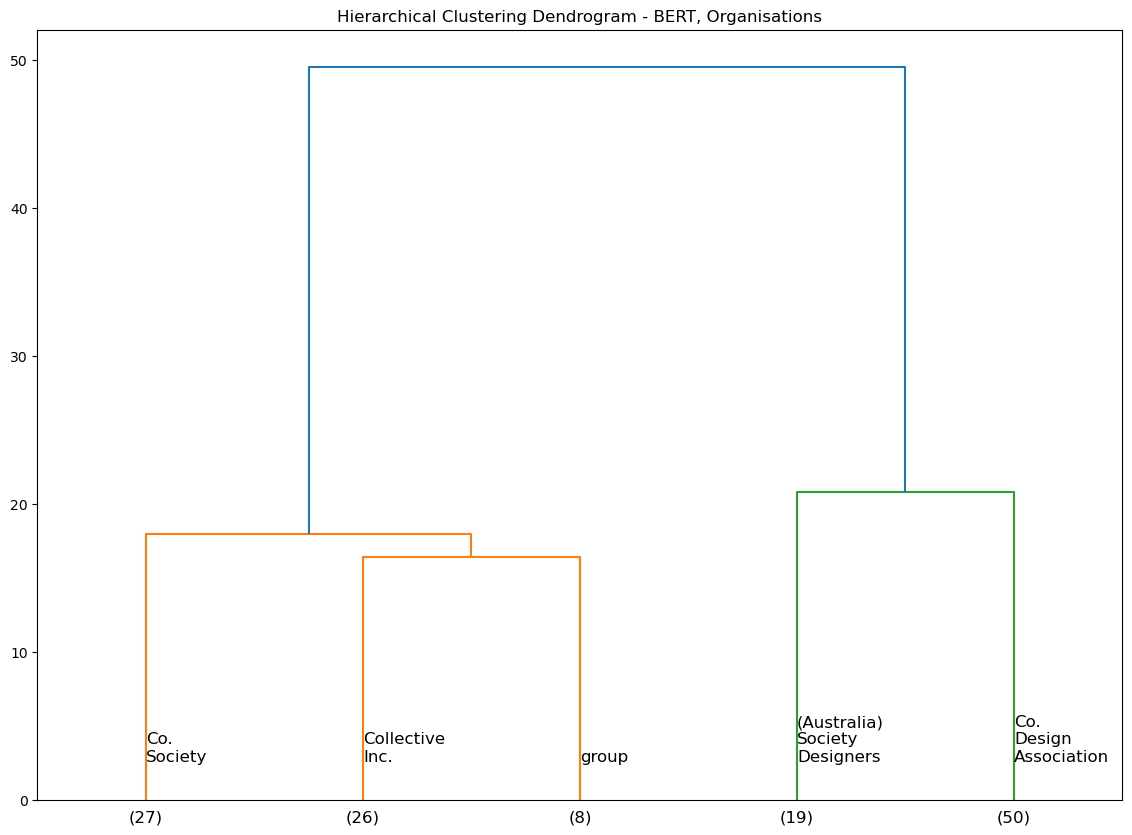

In [35]:
# cut = 5
# l_matrix = get_linkage_matrix(model_bert_org)
# df_org['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df_org['cluster'].unique():
#     cluster_docs = df_org[df_org['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=5))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=4)
# all_words_to_remove.extend(['h','co','e','test','Lapham','J.','Jane','','and','of','&','The','SymbioticA','Nevin','Smith'])

# for i in df_org['cluster'].unique():
#     cluster_docs = df_org[df_org['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=6,
#                                                                        more_words=all_words_to_remove)) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df_org['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df_org['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=12)
    
#     # annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     # annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     # plt.annotate(annot2, xy=(i/df_org['cluster'].nunique()-0.115, -0.24), 
#     #             xytext=(i/df_org['cluster'].nunique()-0.115, -0.24), 
#     #             xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT, Organisations")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output5.png')

In [ ]:
# with open("data/daao_relation.json") as json_file: daao_relation_data=json.load(json_file)
# relation_df = pd.json_normalize(daao_relation_data)
# print(relation_df[((relation_df['obj._cls'] == 'PersonGroup') & (relation_df['subj._cls'] == 'Person'))]['obj._ref.$id.$oid'].shape)

# with open("data/daao_xparty.json") as json_file: daao_xparty_data=json.load(json_file)
# xparty_df = pd.json_normalize(daao_xparty_data)
# xparty_df.head()

# xparty_df[xparty_df['_cls']=='VersionedDocument.XParty.PersonGroup']['primary_name'].value_counts()

# org_df = pd.json_normalize(daoo_org_data)
# org_df[org_df['_id.$oid'].isin(relation_df[(relation_df['obj._cls'] == 'PersonGroup') & (relation_df['subj._cls'] == 'Person')]['obj._ref.$id.$oid'])]

# orgs_ppl = pd.DataFrame()

# for i,row in pd.json_normalize(daoo_org_data).iterrows():
#     try: 
#         related_people = []
#         for j,row2 in pd.json_normalize(row['related_stub_people']).iterrows():
#             related_people.extend([pd.json_normalize(row2['predicate'])['_id.$oid'].values[0], 
#                                 pd.json_normalize(row2['target'])['_id.$oid'].values[0]])

#         ppl = pd.DataFrame({'related_people':list(dict.fromkeys(related_people))})
#         ppl['organisation'] = row['primary_name']
#         orgs_ppl = pd.concat([orgs_ppl, ppl], ignore_index=True)
#     except: continue

## Temporal analysis of venues

To further explore frequently used terms in place names, we produce an interactive time series of the number of events per decade by associated terms.

Before the visuals, we provide an ordered list of the decades with the most event activity, and also a list of the top 20 most frequent terms used in place names.

In [36]:
events_df = clean_data_v2.copy()

# create a new column with the decade of start year
events_df['decade'] = events_df['start_year'].apply(lambda x: str(x)[:3] + '0')
events_df['decade'] = events_df['decade'].apply(lambda x: '2000' if x == '2020' else x)
events_df['decade'] = events_df['decade'].astype(int)
events_df['decade'].value_counts()

1990    1464
2000    1065
1980    1030
1970     506
2010     207
1960      73
1950      35
1940      13
1900       7
1910       6
1930       5
1920       4
Name: decade, dtype: int64

In [37]:
most_freq_words_dict2

{'Art': 2752,
 'Gallery': 2520,
 'University': 478,
 'Contemporary': 475,
 'Centre': 464,
 'Museum': 451,
 'Experimental': 425,
 'Foundation': 425,
 'City': 286,
 'Modern': 286,
 'National': 235,
 'Institute': 230,
 'Regional': 172,
 'Fine': 133,
 'Museums': 121,
 'Australian': 112,
 'Place': 110,
 'Region': 96,
 'Arts': 72,
 'Corner': 43,
 'Streets': 43,
 'School': 41}

In [38]:
words_by_decade = pd.DataFrame()

for key in most_freq_words_dict2:
    words_this_decade = events_df[events_df['address_prompt'].str.contains(key, na=False)]\
                        .groupby('decade')['address_prompt']\
                        .count()\
                        .reset_index(name='count')\
                        .sort_values(['decade'], ascending=True)
    words_this_decade['term'] = key
    words_by_decade = pd.concat([words_by_decade, words_this_decade], ignore_index=True)

In [39]:
import plotly.express as px
fig = px.line(words_by_decade, x="decade", y="count", color='term',
                title='Count of each term by decade')


# # make figure size bigger
# # fig.update_layout(
# #     autosize=False,
# #     width=700,
# #     height=500,
# # )

fig.show()

In [40]:
# events_df['diff'] = events_df['end_year'] - events_df['start_year']
# # events_df[(events_df['place_name'].str.contains('Contemporary')) & (events_df['diff'] > 1)]

# using start_date, end_date, place_name, calculate the difference between start_date of the first event in an venue and end_date of the last event in that venue
places_with_start_end = []
[places_with_start_end.extend([p, events_df.loc[events_df['address_prompt'] == p, 'start_year'].min(), 
                              events_df.loc[events_df['address_prompt'] == p, 'end_year'].max()] for p in events_df['place_address'].unique())]

places_with_start_end = pd.DataFrame(places_with_start_end)
places_with_start_end.columns = ['address_prompt', 'start_year', 'end_year']
places_with_start_end['diff'] = places_with_start_end['end_year'] - places_with_start_end['start_year']
places_with_start_end = places_with_start_end[places_with_start_end['diff'] >= 0]
# places_with_start_end.sort_values('diff', ascending=False)

Beyond the above time series, we also provide a series of bar charts, however instead of illustrating event activity within a certain decade, we plot the number of venues active across time. We calculate the start and end of a venue's "lifespan" by using the earliest and latest event date associated with a venue. We do this by filtering on venues with associated terms in the place name.

Most bar charts follow the same upwards trends shown in the above time series, however some terms that highlight some different trajectories consist of "contemporary", "society", "experimental" and "space".

In [41]:
decade_placeholder = pd.DataFrame([0] * 13, index=range(1900, 2020+1, 10)).reset_index().rename(columns={'index':'decade', 0:'count'})
decade_placeholder['decade'] = decade_placeholder['decade'].astype(str)

for term in most_freq_words_dict2:
    # create a wide form of contemporary with each decade as a column and a binary value for whether the venue existed in that decade
    # use start_year as the start and end_year as the end of the venue
    contemporary = places_with_start_end[(places_with_start_end['address_prompt'].str.contains(term))].sort_values('start_year', ascending=True)
    contemporary_wide = pd.DataFrame()

    for i,row in contemporary.iterrows():
        for year in range(int(row['start_year']), int(row['end_year'])+1): 
            contemporary_wide.loc[row['address_prompt'], str(year)[:3] + '0'] = 1

    contemporary_wide = contemporary_wide.\
        fillna(0).\
        reset_index().\
        rename(columns={'index':'address_prompt'}).\
        sum().tail(-1).\
        reset_index().\
        rename(columns={'index':'decade', 0:'count'})
    
    contemporary_wide = pd.merge(contemporary_wide, decade_placeholder, on='decade', how='outer')
    contemporary_wide['count'] = contemporary_wide['count_x'] + contemporary_wide['count_y']
    contemporary_wide = contemporary_wide[['decade', 'count']].sort_values('decade', ascending=True)

    fig = px.bar(contemporary_wide, x="decade", y='count',
                    title=f'Number of venues that existed in each decade, {term}')

    # remove y-axis label
    fig.update_yaxes(title_text='')
    fig.update_xaxes(title_text='')

    # # make figure size bigger
    # fig.update_layout(
    #     autosize=False,
    #     width=700,
    #     height=400,
    # )

    fig.show()

### Proportions
We repeat the same temporal visuals as above, however this time we plot the proportions to effectively normalise the data with respect to the number of events across decades, and the number of venues that existed across time, repsectively.

Note that the y-axis limits in the bar charts changes for each term.

In [42]:
words_by_decade_prop = []

# find the proportions of each word in each decade
for i in most_freq_words_dict2.keys():
    for j in events_df['decade'].unique():
        prop = events_df[(events_df['address_prompt'].str.contains(i)) & (events_df['decade'] == j)].shape[0] /events_df[events_df['decade'] == j].shape[0]
        words_by_decade_prop.append([i,j,prop])
    
words_by_decade_prop = pd.DataFrame(words_by_decade_prop)
words_by_decade_prop.columns = ['word','decade','proportion']

In [43]:
# plot proportion of each term by decade
# make it interactive

import plotly.express as px

fig = px.line(words_by_decade_prop.sort_values('decade'), x="decade", y="proportion", color='word',
                title='Proportion of each term by decade')

# make figure size bigger
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=500,
# )

fig.show()

In [44]:
allplaces_wide = pd.DataFrame()

for i,row in places_with_start_end.iterrows():
    for year in range(int(row['start_year']), int(row['end_year'])+1): 
        allplaces_wide.loc[row['address_prompt'], str(year)[:3] + '0'] = 1

decade_placeholder_forprop = allplaces_wide.\
                            fillna(0).\
                            reset_index().\
                            rename(columns={'index':'address_prompt'}).\
                            sum().tail(-1).\
                            reset_index().\
                            rename(columns={'index':'decade', 0:'count'}).\
                            sort_values('decade', ascending=True)

In [45]:
for term in most_freq_words_dict2:
    # create a wide form of contemporary with each decade as a column and a binary value for whether the venue existed in that decade
    # use start_year as the start and end_year as the end of the venue
    contemporary = places_with_start_end[(places_with_start_end['address_prompt'].str.contains(term))].sort_values('start_year', ascending=True)
    contemporary_wide = pd.DataFrame()

    for i,row in contemporary.iterrows():
        for year in range(int(row['start_year']), int(row['end_year'])+1): 
            contemporary_wide.loc[row['address_prompt'], str(year)[:3] + '0'] = 1

    contemporary_wide = contemporary_wide.\
        fillna(0).\
        reset_index().\
        rename(columns={'index':'address_prompt'}).\
        sum().tail(-1).\
        reset_index().\
        rename(columns={'index':'decade', 0:'count'})
    
    contemporary_wide = pd.merge(contemporary_wide, decade_placeholder_forprop, on='decade', how='outer')
    contemporary_wide['prop'] = np.where(contemporary_wide['count_x'] > 0, 
                                     contemporary_wide['count_x']/contemporary_wide['count_y'], 0)
    contemporary_wide = contemporary_wide[['decade', 'prop']].sort_values('decade', ascending=True)

    fig = px.bar(contemporary_wide, x="decade", y='prop',
                    title=f'Number of venues that existed in each decade, {term}')

    # remove y-axis label
    fig.update_yaxes(title_text='')
    fig.update_xaxes(title_text='')

    # make figure size bigger
    # fig.update_layout(
    #     autosize=False,
    #     width=700,
    #     height=400,
    # )

    fig.show()